In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
import warnings
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter1d

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['errorbar.capsize'] = 4
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 0
mpl.rcParams['font.size'] = 6
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['xtick.major.pad'] = 2.5
mpl.rcParams['ytick.major.pad'] = 2.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.labelpad'] = 6
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['legend.fontsize'] = 6
mpl.rcParams['legend.handletextpad'] = 2.5
mpl.rcParams['legend.borderpad'] = 0
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = (6.45, 2.58)
mpl.rcParams['figure.subplot.wspace'] = 0.25
mpl.rcParams['figure.subplot.hspace'] = 0.25
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42
colors = ['296eb4', 'e10600', '00A676', 'B74F6F', 'FF6B35',
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)

# Personal
sys.path.append('/home1/john/Goldmine/general')
sys.path.append('/home1/john/Goldmine/time_cells_goldmine')
%load_ext autoreload
%autoreload
# sys.path.append('/home1/dscho/code/general')
# sys.path.append('/home1/dscho/code/projects/manning_replication')
# sys.path.append('/home1/dscho/code/projects')
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, time_cell_plots, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])


In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Load the data

In [2]:
# Get sessions.

# original
# proj_dir = '/home1/dscho/projects/time_cells'
proj_dir = '/data7/goldmine'

sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
n_rois = 4

# Load processed OLS files.
mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_model_pairs.pkl')
ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav_1000perm', '*Encoding_Retrieval-ols_weights.pkl')
# mod_pairs_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav', '*Encoding_Retrieval-ols_model_pairs.pkl')
# ols_weights_globstr = op.join(proj_dir, 'analysis', 'unit_to_behav', '*Encoding_Retrieval-ols_weights.pkl')
time_field_globstr = op.join(proj_dir, 'analysis', 'time_fields', '*Encoding_Retrieval-smooth3*.pkl')
mod_pairs = pd.concat([dio.open_pickle(f) for f in glob(mod_pairs_globstr)]).reset_index(drop=True)
ols_weights = pd.concat([dio.open_pickle(f) for f in glob(ols_weights_globstr)]).reset_index(drop=True)
time_fields = pd.concat([dio.open_pickle(f)['time_fields'] for f in glob(time_field_globstr)]).reset_index(drop=True)

# Drop rows.
drop_red = ['full-time,gameState:time', 'full-place,gameState:place',
            'fullMax-time,gameState:time', 'fullMax-place,gameState:place',
            'full+penalty-time:penalty', 'full+penalty-place:penalty',
            'full+goldDug-time:goldDug', 'full+goldDug-place:goldDug',
            'fullMax+penalty-time:penalty', 'fullMax+penalty-place:penalty',
            'fullMax+goldDug-time:goldDug', 'fullMax+goldDug-place:goldDug']
mod_pairs = mod_pairs.query("(red!={})".format(drop_red)).reset_index(drop=True)

# Add columns.
_map = od({'full-gameState'                : 'gameState',
           'full-time'                     : 'time',
           'full-gameState:time'           : 'gameState:time',
           'full-place'                    : 'place',
           'full-gameState:place'          : 'gameState:place',
           'full-time:place'               : 'time:place',
           'full+penalty-time:penalty'     : 'time:penalty',
           'full+penalty-place:penalty'    : 'place:penalty',
           'full+goldDug-time:goldDug'     : 'time:goldDug',
           'full+goldDug-place:goldDug'    : 'place:goldDug',
            'fullMax-gameState'             : 'max-gameState',
            'fullMax-time'                  : 'max-time',
            'fullMax-gameState:time'        : 'max-gameState:time',
            'fullMax-place'                 : 'max-place',
            'fullMax-gameState:place'       : 'max-gameState:place',
            'fullMax-time:place'            : 'max-time:place',
           # 'fullMax-gameState'             : 'gameState', # to replicate what was there in terms of cell counts comment out these 6 and uncomment 6 above
           # 'fullMax-time'                  : 'time',
           # 'fullMax-gameState:time'        : 'gameState:time',
           # 'fullMax-place'                 : 'place',
           # 'fullMax-gameState:place'       : 'gameState:place',
           # 'fullMax-time:place'            : 'time:place',
           'fullMax+penalty-time:penalty'  : 'time:penalty',
           'fullMax+penalty-place:penalty' : 'place:penalty',
           'fullMax+goldDug-time:goldDug'  : 'time:goldDug',
           'fullMax+goldDug-place:goldDug' : 'place:goldDug'})

testvar_cat = pd.CategoricalDtype(['gameState', 'time', 'gameState:time', 'place', 'gameState:place', 'time:place',
                                   'max-gameState', 'max-time', 'max-gameState:time', 'max-place', 'max-gameState:place', 'max-time:place',
#                                    'time:penalty', 'place:penalty', 'time:goldDug', 'place:goldDug',                                  
#                                    'max-time:penalty', 'max-place:penalty', 'max-time:goldDug', 'max-place:goldDug'
                                  ], ordered=True)
mod_pairs.insert(4, 'testvar', mod_pairs['red'].apply(lambda x: _map[x]))
mod_pairs['testvar'] = mod_pairs['testvar'].astype(testvar_cat)
mod_pairs.insert(1, 'subj', mod_pairs['subj_sess_unit'].apply(lambda x: x.split('_')[0]))
roi_map = spike_preproc.roi_mapping(n=n_rois)
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+1, 'roi_gen', mod_pairs['roi'].apply(lambda x: roi_map.get(x, np.nan)))
mod_pairs.insert(mod_pairs.columns.tolist().index('roi')+2, 'is_hpc', mod_pairs['roi_gen'].apply(lambda x: x == 'HPC'))

# Add time field info.
for game_state in ['Encoding', 'Retrieval']:
    _time_fields = (time_fields.query("(field_type=='pos') & (gameState=='{}')".format(game_state))
                               .sort_values('peak_z', ascending=False)
                               .drop_duplicates(['subj_sess_unit'])
                               .reset_index(drop=True))
    cols = ['subj_sess_unit', 'field_peak', 'peak_z', 'field_size', 'field_idx']
    mod_pairs = pd.merge(mod_pairs, _time_fields[cols], how='left', on=['subj_sess_unit'])
    mod_pairs.rename(columns={col: '{}_{}'.format(col, game_state)
                              for col in ['field_peak', 'peak_z', 'field_size', 'field_idx']},
                     inplace=True)

# Get region labels.

# rois_if = od([('HPC', ['AH', 'MH']),
#               ('AMY', ['A']),
#               ('ERCX', ['EC']),
#               ('PHG/FSG', ['PHG', 'FSG']),
#               ('HSG', ['HGa']),
#               ('mOCC', ['mOCC']),
#               ('mPFC', ['OF', 'AC', 'pSMA']),
#               ('Other', ['AI', 'PC', 'PI'])])
for df in (mod_pairs, ols_weights):
    # only want roi (subregion), hem (L or R), and roi_gen (general region from roi_mapping) # JS
    df.drop(columns=[col for col in ['hemroi', 'roi_if', 'roi_gen', 'is_hpc'] if col in df.columns], inplace=True)
    
    # Generate mapping dictionary for roi → roi_gen
    roi_map = spike_preproc.roi_mapping(n=n_rois)

    # Add 'roi_gen' by mapping existing 'roi' values
    df.insert(2, 'roi_gen', df['roi'].map(roi_map).fillna('Unknown'))    
    
    # df.drop(columns=[col for col in ['hemroi', 'hem', 'roi', 'roi_if'] if col in df.columns], inplace=True)    
    # df.insert(1, 'hemroi', df['subj_sess_unit'].apply(lambda x: spike_preproc.roi_lookup(x.split('-')[0], x.split('-')[1])))
    # df.insert(2, 'hem', df['hemroi'].apply(lambda x: x[0]))
    # df.insert(3, 'roi', df['hemroi'].apply(lambda x: x[1:]))
    # df.insert(4, 'roi_if', df['roi'].apply(lambda x: invert_dict(rois_if)[x]))
    
print('mod_pairs: {}'.format(mod_pairs.shape))
print('ols_weights: {}'.format(ols_weights.shape))
print('time_fields: {}'.format(time_fields.shape))

mod_pairs: (5484, 24)
ols_weights: (529206, 10)
time_fields: (444, 8)


In [4]:
# FDR correct across all neurons.
alpha = 0.05
sig_col = 'sig'

mod_pairs['sig01'] = ''
mod_pairs['sig_fdr'] = ''
for testvar in mod_pairs['testvar'].unique():
    pvals = mod_pairs.loc[mod_pairs['testvar']== testvar, 'emp_pval']
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    pvals_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[1]
    
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig01'] = pvals < 0.01
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'pvals_fdr'] = pvals_fdr
    mod_pairs.loc[mod_pairs['testvar']==testvar, 'sig_fdr'] = sig_fdr
    
sig_cells = od([])
for testvar in mod_pairs['testvar'].unique():
    sig_cells[testvar] = mod_pairs.query("(testvar=='{}') & ({}==True)".format(testvar, sig_col))['subj_sess_unit'].tolist()

In [5]:
# How many neurons for each subject, from each region?
roi_col = 'roi_gen'
neuron_counts = (pd.pivot(mod_pairs.drop_duplicates('subj_sess_unit')
                                   .groupby(['subj', roi_col])
                                   .size()
                                   .reset_index()
                                   .rename(columns={0: 'count'}),
                          index='subj', columns='roi_gen', values='count')
                 .fillna(0)
                 .astype(int))

idx = np.argsort(neuron_counts.sum(axis=1))[::-1]
neuron_counts = neuron_counts.iloc[idx, :]
neuron_counts = neuron_counts.append(neuron_counts.sum(axis=0), ignore_index=True)
neuron_counts.columns.name = None
neuron_counts['Sum'] = neuron_counts.sum(axis=1)

neuron_counts

,HPC,MTL,PFC,TPC,Sum
0,11,61,9,21,102
1,9,37,27,0,73
2,19,19,0,28,66
3,24,25,1,15,65
4,14,3,15,11,43
5,9,16,8,0,33
6,11,6,8,0,25
7,5,19,0,0,24
8,4,9,0,0,13
9,3,9,1,0,13


In [6]:
# What variables have >chance numbers of sig. cells?
testvars = ['gameState', 'time', 'gameState:time',
            'place', 'gameState:place', 'time:place']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>2}/{:>2} {:>5.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))
    
# ---------------------------------------------------------------
testvars = ['max-gameState', 'max-time', 'max-gameState:time',
            'max-place', 'max-gameState:place', 'max-time:place']

count_sig = od([])
count_all = od([])
n_cells = mod_pairs['subj_sess_unit'].unique().size
pvals_unc = od([])
for testvar in testvars:
    n_sig = len(sig_cells[testvar])
    binom_p = stats.binom_test(n_sig,
                               n_cells,
                               p=0.05,
                               alternative='greater')
    count_sig[testvar] = n_sig
    count_all[testvar] = n_cells
    pvals_unc[testvar] = binom_p

# Bonferroni-Holm correct
pvals_corr = sm.stats.multipletests(list(pvals_unc.values()), method='holm')[1]

print('')
for iTest, testvar in enumerate(pvals_unc):
    print('{:>19}'.format(testvar),
          '{:>2}/{:>2} {:>5.1%} '.format(count_sig[testvar], count_all[testvar], (1. * count_sig[testvar]) / count_all[testvar]),
          '{:.10f}{:>1}'.format(pvals_unc[testvar], '*' if (pvals_unc[testvar] < alpha) else ''),
          '{:.10f}{:>1}'.format(pvals_corr[iTest], '*' if (pvals_corr[iTest] < alpha) else ''))

          gameState 59/457 12.9%  0.0000000000* 0.0000000002*
               time 23/457  5.0%  0.5170858077  0.7023441694 
     gameState:time 64/457 14.0%  0.0000000000* 0.0000000000*
              place 60/457 13.1%  0.0000000000* 0.0000000001*
    gameState:place 25/457  5.5%  0.3511720847  0.7023441694 
         time:place 43/457  9.4%  0.0000676592* 0.0002029775*

      max-gameState 43/457  9.4%  0.0000676592* 0.0002706367*
           max-time 20/457  4.4%  0.7591101636  0.8641566543 
 max-gameState:time 45/457  9.8%  0.0000155170* 0.0000775851*
          max-place 48/457 10.5%  0.0000014330* 0.0000085979*
max-gameState:place 24/457  5.3%  0.4320783271  0.8641566543 
     max-time:place 42/457  9.2%  0.0001363121* 0.0004089364*


# Percent responses to each variable

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


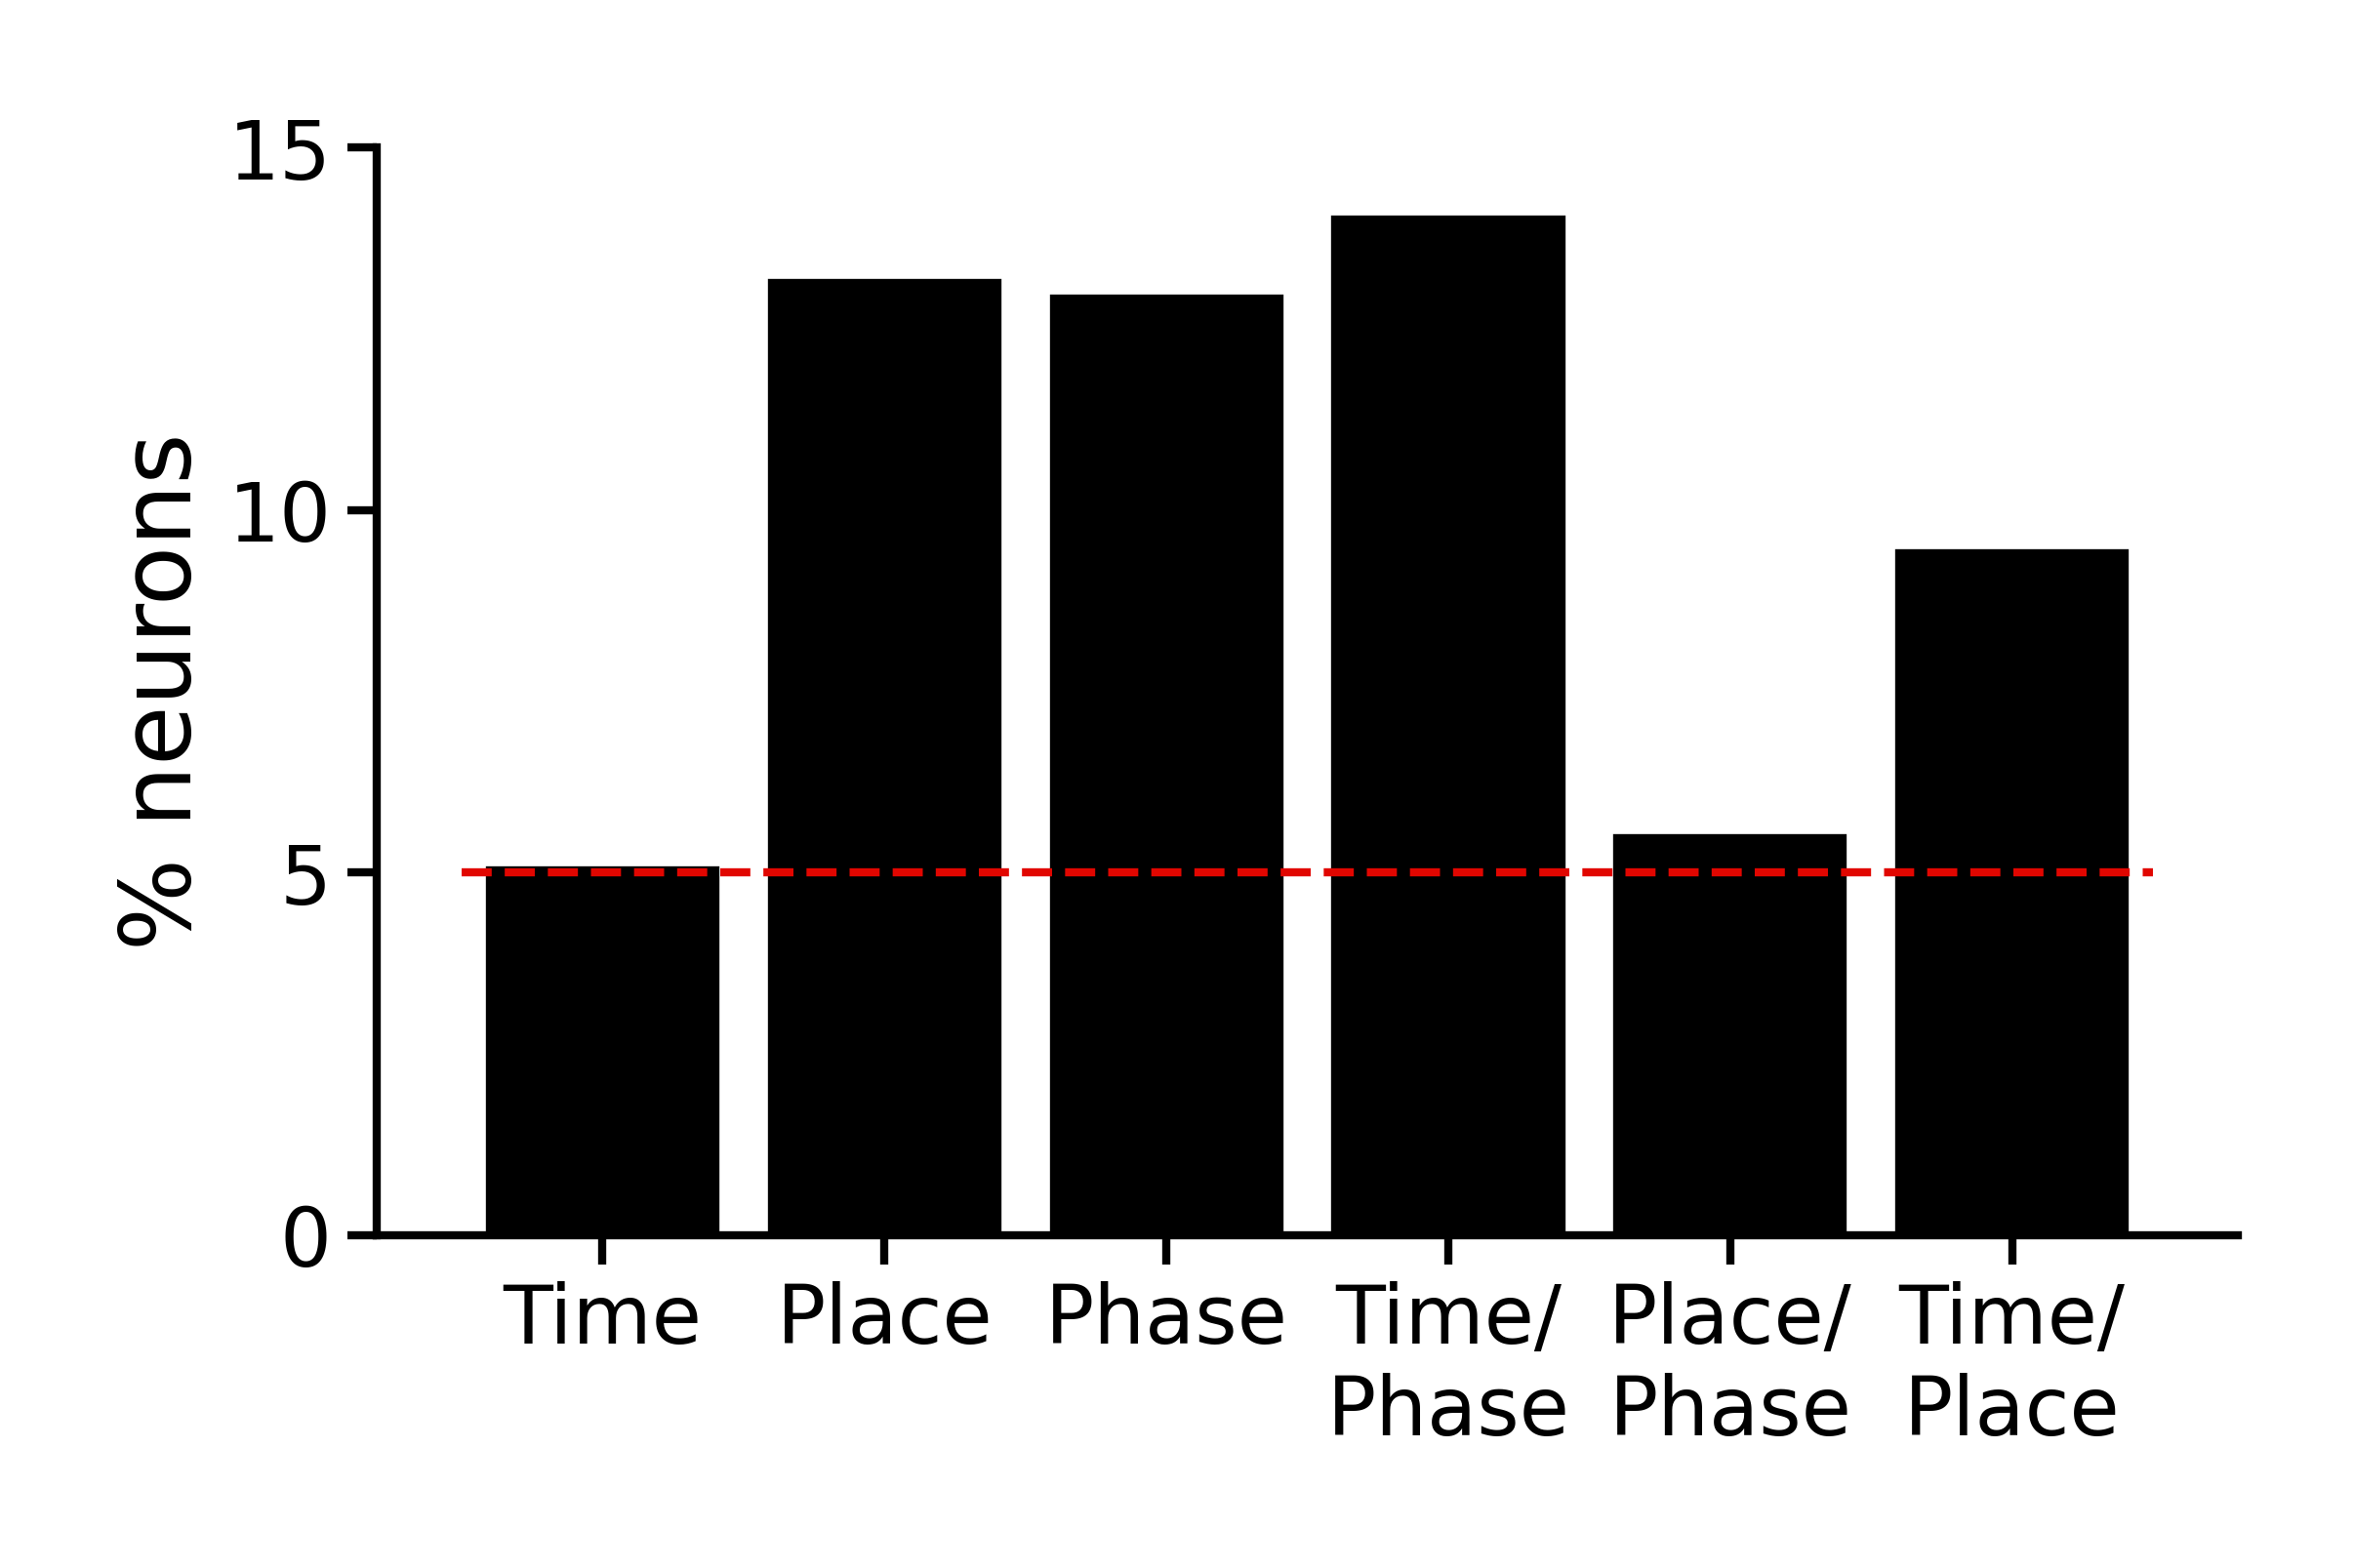

In [7]:
savefig = 0
overwrite = 0
sig_col = 'sig'
full = 'full'
test_vars = ['time', 'place', 'gameState', 'gameState:time', 'gameState:place', 'time:place']
xcats = ['Time', 'Place', 'Phase', 'Time/\nPhase', 'Place/\nPhase', 'Time/\nPlace']
ylim = [0, 15]
yticks = [0, 5, 10, 15]
figsize = (colws[1], colws[1] * 0.6)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2

# Graph percent of units that code for each variable of interest.
_df = mod_pairs.query("(full=='{}')".format(full)).copy()
_df['testvar'] = _df['testvar'].astype(pd.CategoricalDtype(test_vars, ordered=True))
_df = _df.groupby(['testvar'], observed=True)['sig'].apply(lambda x: 100 * np.mean(x)).reset_index()

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='testvar', y='sig', color='k', data=_df, ax=ax,
                 saturation=1, linewidth=spine_lw, edgecolor='k')
ax.hlines(5, -0.5, len(test_vars) - 0.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

if savefig:
    n_units = np.unique(mod_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation2',
                       'pct_sig-time_place_gameState_+interactions-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show();

In [9]:
mod_pairs.query("(full=='fullMax')")['testvar'].unique()

['max-gameState', 'max-time', 'max-gameState:time', 'max-place', 'max-gameState:place', 'max-time:place']
Categories (12, object): ['gameState' < 'time' < 'gameState:time' < 'place' ... 'max-gameState:time' < 'max-place' < 'max-gameState:place' < 'max-time:place']

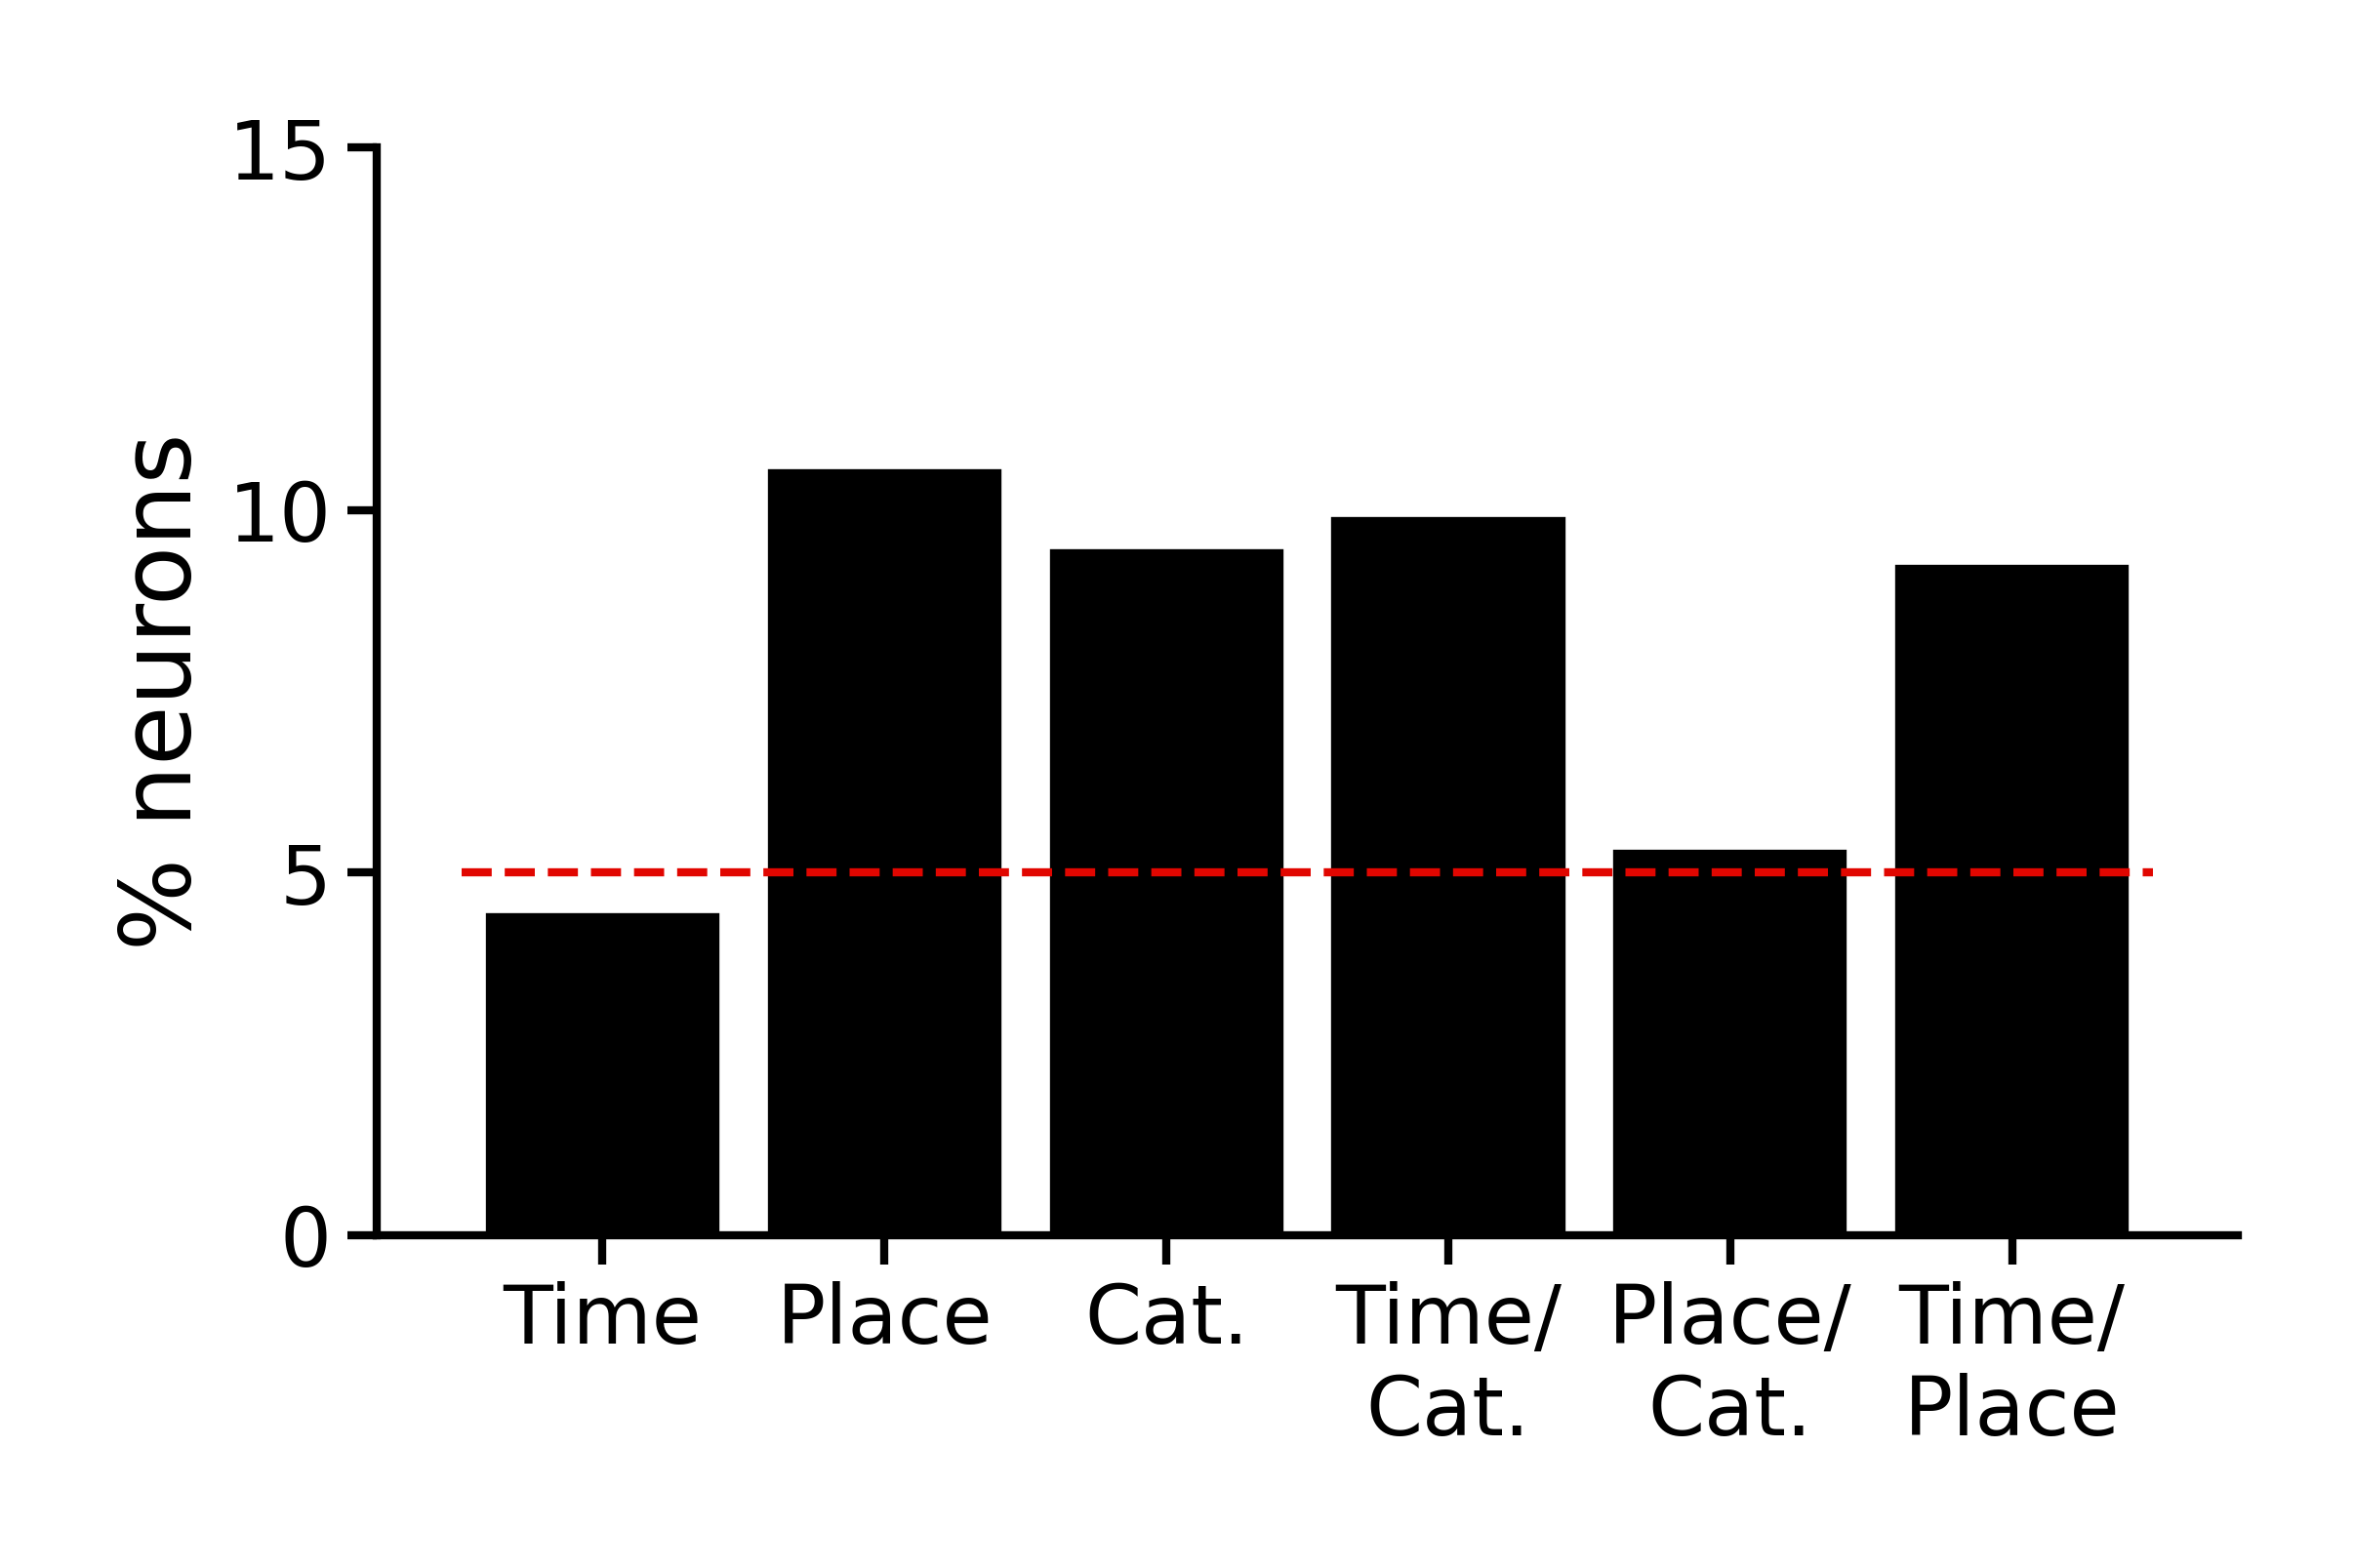

In [10]:
savefig = 0
overwrite = 0
sig_col = 'sig'
full = 'fullMax'
test_vars = ['max-time', 'max-place', 'max-gameState', 'max-gameState:time', 'max-gameState:place', 'max-time:place']
xcats = ['Time', 'Place', 'Cat.', 'Time/\nCat.', 'Place/\nCat.', 'Time/\nPlace']
ylim = [0, 15]
yticks = [0, 5, 10, 15]
figsize = (colws[1], colws[1] * 0.6)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2

# Graph percent of units that code for each variable of interest.
_df = mod_pairs.query("(full=='{}')".format(full)).copy()
_df['testvar'] = _df['testvar'].astype(pd.CategoricalDtype(test_vars, ordered=True))
_df = _df.groupby(['testvar'], observed=True)['sig'].apply(lambda x: 100 * np.mean(x)).reset_index()

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='testvar', y='sig', color='k', data=_df, ax=ax,
                 saturation=1, linewidth=spine_lw, edgecolor='k')
ax.hlines(5, -0.5, len(test_vars) - 0.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

if savefig:
    n_units = np.unique(mod_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation2',
                       'pct_sig-time_place_gameState_+interactions-{}units-fullMax.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show();

# Single-cell examples: time, place, head direction, and view coding

In [13]:
# neurons = ['U518_ses0-4-1', 'U532_ses0-4-1', 'U530_ses0-13-1', 'U518_ses0-73-1', 'U518_ses1-38-1', 'U532_ses0-10-1',
#            'U532_ses0-5-8', 'U530_ses0-3-2', 'U526_ses0-12-2', 'U518_ses0-73-1', 'U527_ses0-58-2', 'U532_ses0-8-2',
#            'U518_ses1-43-2', 'U532_ses0-4-3', 'U532_ses0-3-2', 'U518_ses1-36-1']
# Time: 
# array(['U554_ses0-9-1', 'U554_ses0-39-1', 'U554_ses0-39-1',
       # 'U554_ses0-40-1', 'U554_ses0-40-1', 'U563_ses0-22-1',
       # 'U563_ses0-21-1', 'U563_ses0-21-1', 'U563_ses0-30-1',
       # 'U563_ses0-58-1', 'U563_ses0-58-1'], dtype='<U14')
# Time x gameState:
# array(['U554_ses0-6-1', 'U554_ses0-6-1', 'U554_ses0-9-1', 'U554_ses0-9-1',
#        'U554_ses0-10-2', 'U554_ses0-29-1', 'U554_ses0-29-1',
#        'U555_ses0-1-1', 'U555_ses0-1-1', 'U554_ses0-58-1',
#        'U555_ses0-11-1', 'U555_ses0-11-1', 'U563_ses0-31-1'], dtype='<U14')
# U554_ses0-10-2 and U554_ses0-58-1 weirdly similar responses

cell_name = 'U554_ses0-58-1'

print(f"{cell_name} → ROI: {mod_pairs.loc[mod_pairs['subj_sess_unit'] == cell_name, 'roi'].iloc[0]}, Hemisphere: {mod_pairs.loc[mod_pairs['subj_sess_unit'] == cell_name, 'hem'].iloc[0]}, ROI_gen: {mod_pairs.loc[mod_pairs['subj_sess_unit'] == cell_name, 'roi_gen'].iloc[0]}")


U554_ses0-58-1 → ROI: A, Hemisphere: R, ROI_gen: MTL


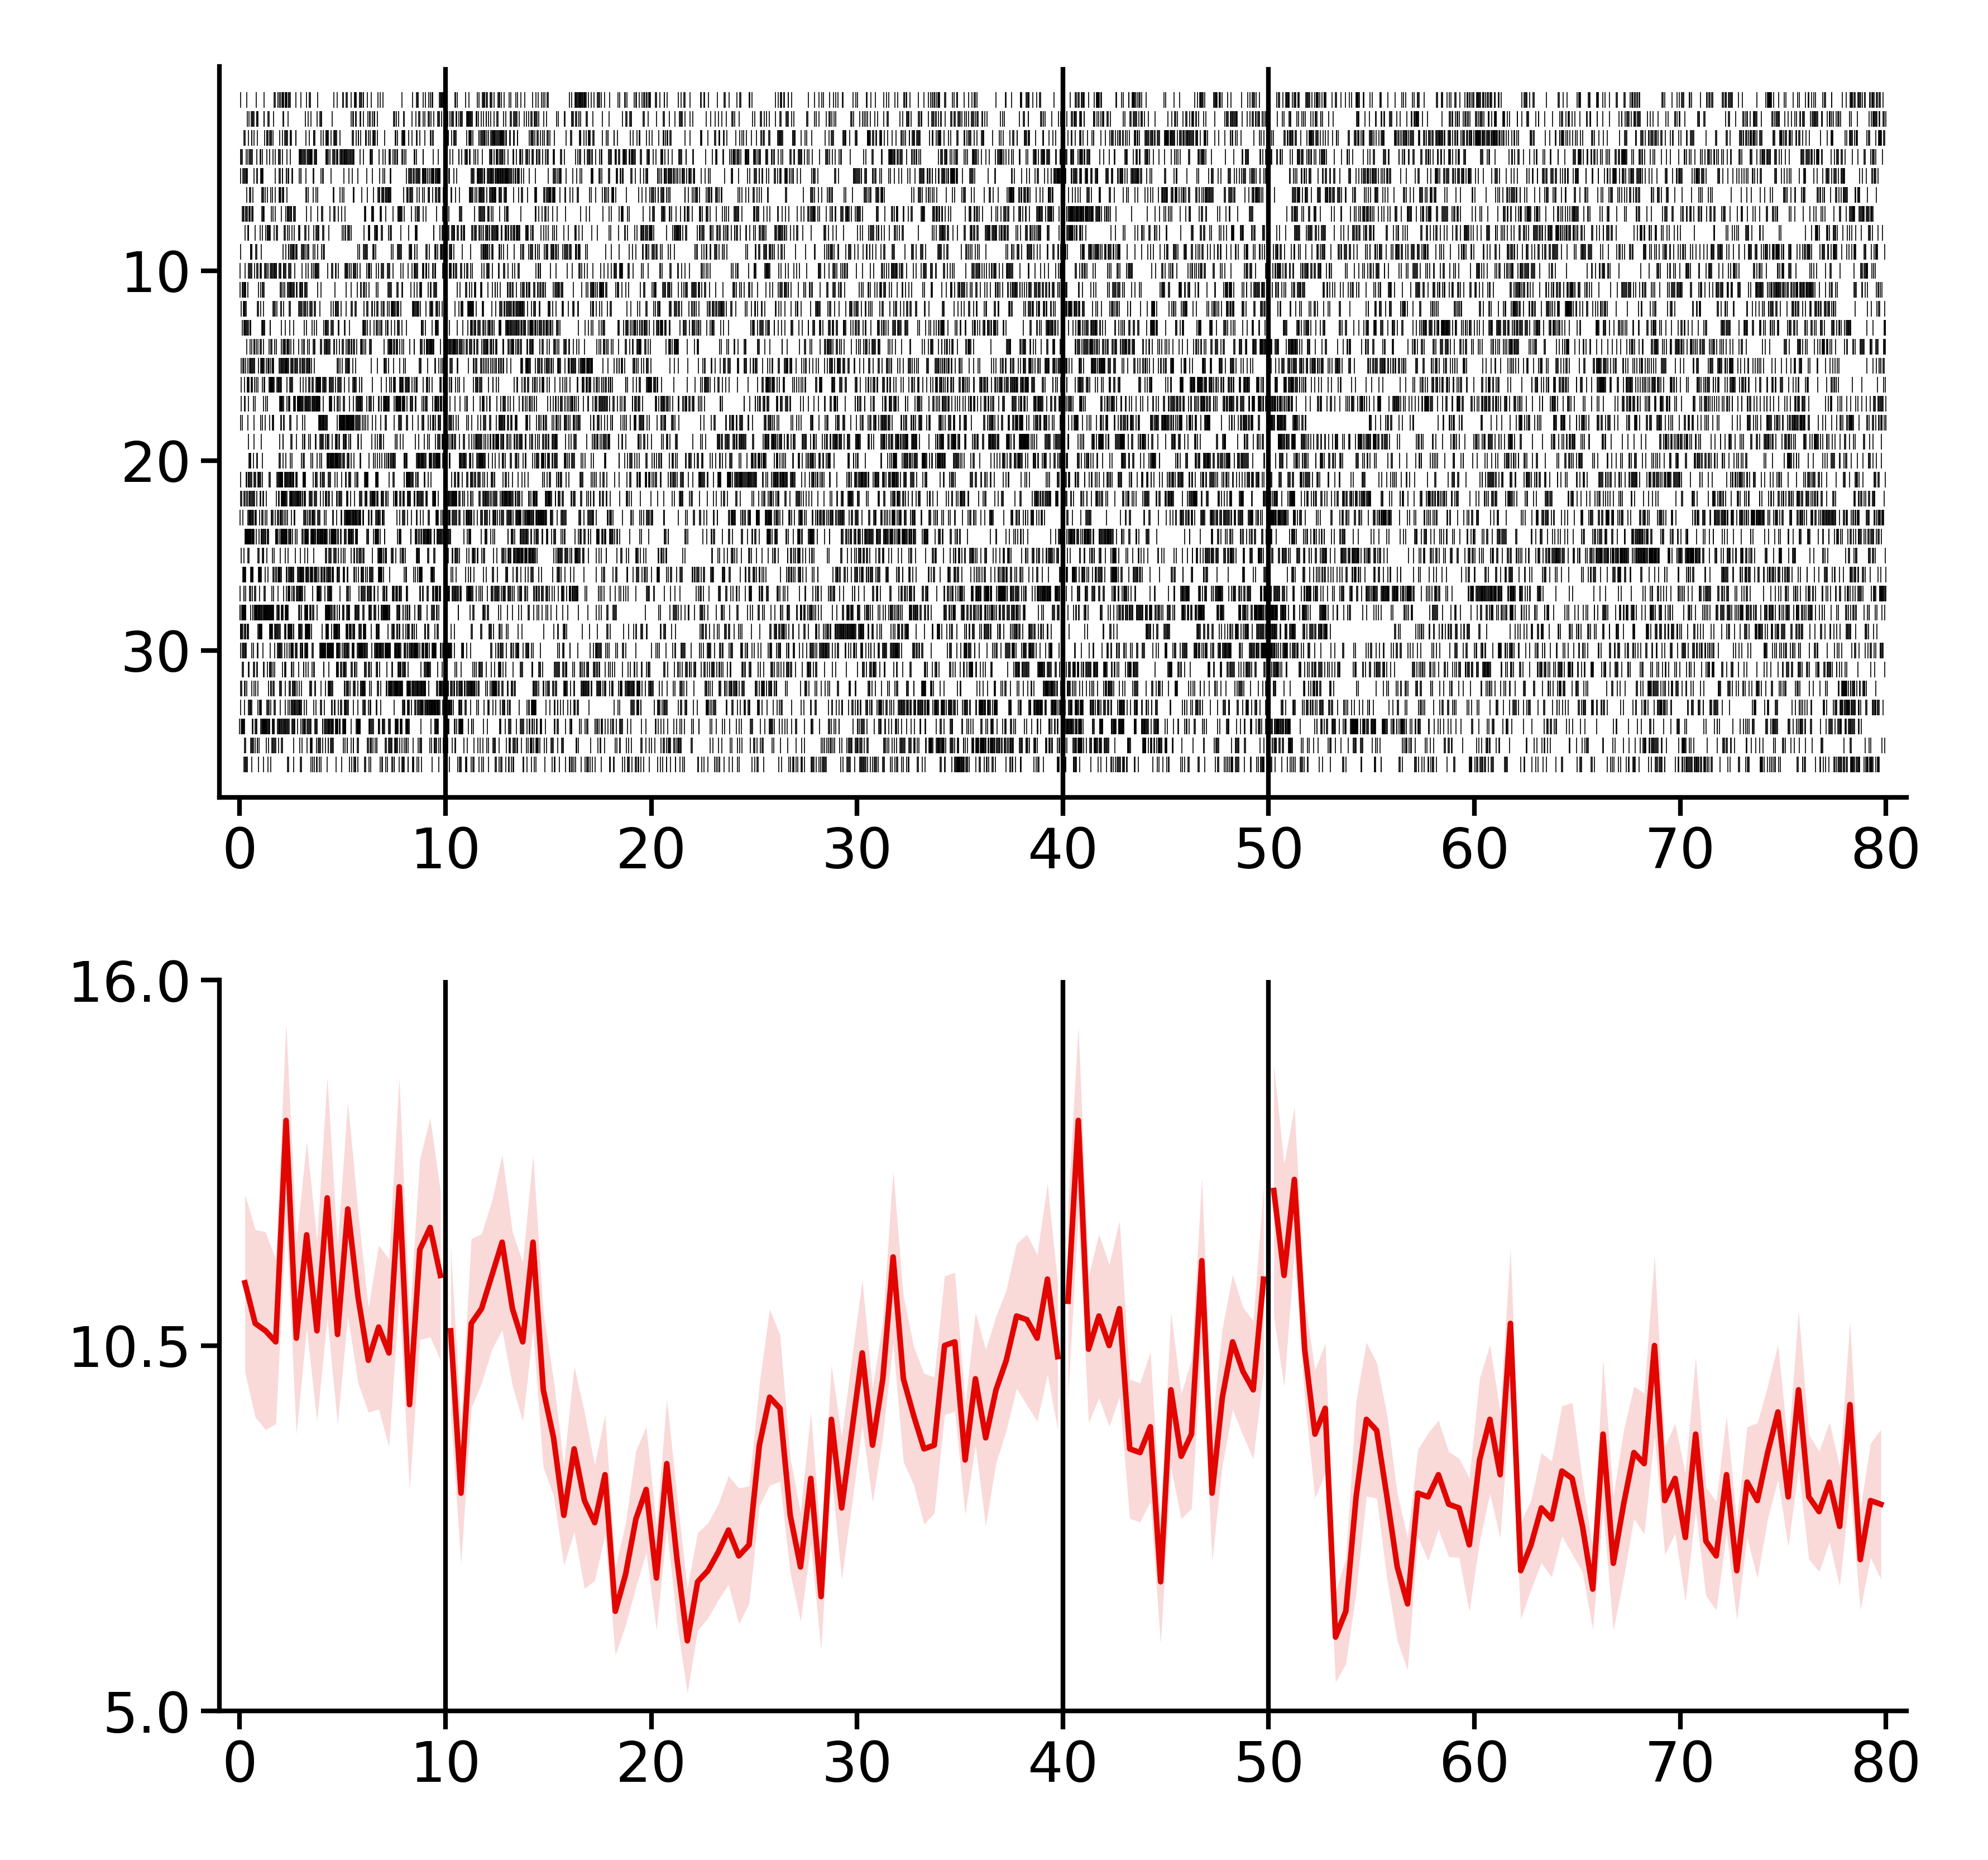

In [14]:
# Save raster and firing rate plots for chosen neuron.
subj_sess_unit = 'U554_ses0-58-1'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 0
overwrite = 1
figsize = (3.25, 3.25)
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 0
rastersize = 1.7
rasterwidth = 0.1

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      proj_dir = '/data7/gemmine',
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)
iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=plot_title,
                                                proj_dir = '/data7/gemmine',
                                                ax=ax[iax],
                                                font=font,
                                                labelpad=labelpad,
#                                                 ymin=1.5,
#                                                 ymax=1.5,
#                                                 yticks=[1, 3, 5],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

In [15]:
# # Place:
# array(['U554_ses0-9-2', 'U563_ses0-16-1', 'U563_ses0-16-1',
#        'U563_ses0-22-1', 'U563_ses0-22-1', 'U563_ses0-41-1',
#        'U563_ses0-31-1', 'U563_ses0-31-1'], dtype='<U14')

units = ['U554_ses0-9-2', 'U563_ses0-16-1', 'U563_ses0-16-1',
       'U563_ses0-22-1', 'U563_ses0-22-1', 'U563_ses0-41-1',
       'U563_ses0-31-1', 'U563_ses0-31-1']
cols = ['subj_sess_unit', 'hem', 'roi', 'gameState', 'testvar', 'full', 'z_lr', 'emp_pval', 'sig_holm', 'fr_mean', 'fr_max']
# _units = ['U518_ses1-43-2', 'U521_ses0-21-1', 'U532_ses0-4-3']



In [16]:
mod_pairs.keys()
np.unique(mod_pairs['testvar'])
np.unique(mod_pairs['full'])

Index(['subj_sess_unit', 'subj', 'roi_gen', 'hem', 'roi', 'gameState',
       'testvar', 'full', 'red', 'llf_full', 'llf_red', 'df', 'lr', 'z_lr',
       'emp_pval', 'sig', 'sig01', 'sig_fdr', 'pvals_fdr'],
      dtype='object')

array(['gameState', 'gameState:place', 'gameState:time', 'max-gameState',
       'max-gameState:place', 'max-gameState:time', 'max-place',
       'max-time', 'max-time:place', 'place', 'time', 'time:place'],
      dtype=object)

array(['full', 'fullMax'], dtype=object)

# Time cell heatmaps

In [7]:
from sklearn.preprocessing import minmax_scale
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
import os
import pickle

def load_spikes_from_pkl(subj_sess: str, XX: int, YY: int, proj_dir = "/data7/goldmine/"):
    """
    Load a spike pickle file given the subject-session, CSC number, and unit number.

    Parameters
    ----------
    subj_sess : str
        e.g. "U554_ses0"
    XX : int
        The CSC channel number
    YY : int
        The unit number

    Returns
    -------
    spikes : pandas.Series
        The loaded spikes info
    """
    fname = f"{subj_sess}-CSC{XX}-unit{YY}-spikes.pkl"
    path = os.path.join(proj_dir, "analysis", "spikes", fname)

    if not os.path.exists(path):
        raise FileNotFoundError(f"Spike file not found:\n{path}")

    with open(path, "rb") as f:
        spikes = pickle.load(f)
    return spikes

def parse_neuron_name(neuron: str, subj_sess: str):
    """
    Parse neuron string to extract CSC and unit numbers.

    Parameters
    ----------
    neuron : str
        e.g. 'U554_ses0-40-1'
    subj_sess : str
        e.g. 'U554_ses0'

    Returns
    -------
    XX : int
        CSC channel number
    YY : int
        unit number
    """
    suffix = neuron.replace(subj_sess + "-", "")
    XX_str, YY_str = suffix.split("-")
    return int(XX_str), int(YY_str)

def get_spike_mat_unsmoothed(subj_sess_unit,game_state,proj_dir = "/data7/gemmine/"):

    # This previously had some sort of smoothing but I do this right in the nav_time_JS JLab notebook now
    
    # Load the data.
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess,
                                                       proj_dir=proj_dir,
                                                       verbose=False)
    spike_mat = event_spikes.get_spike_mat(neuron, game_state) #* float(mult) # I dunno the purpose of this mult
    
    # # Smooth spike counts over time, separately for each trial and game_state.
    # if smooth:
    #     spike_mat_smooth = np.array([gaussian_filter1d(spike_mat.values[iTrial, :], smooth)
    #                                  for iTrial in range(spike_mat.shape[0])])
    #     spike_mat_smooth = pd.DataFrame(spike_mat_smooth, index=spike_mat.index, columns=spike_mat.columns)
        
    return spike_mat # trial x time_bin

def _combine_time_bins(spike_mat: np.ndarray, bins: int = 60) -> np.ndarray:
    """Return sum of spikes across trials within each time bin."""
    if len(spike_mat.shape) == 2:
        return np.array([v.sum() for v in np.array_split(np.sum(spike_mat, axis=0), bins)])
    return None

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


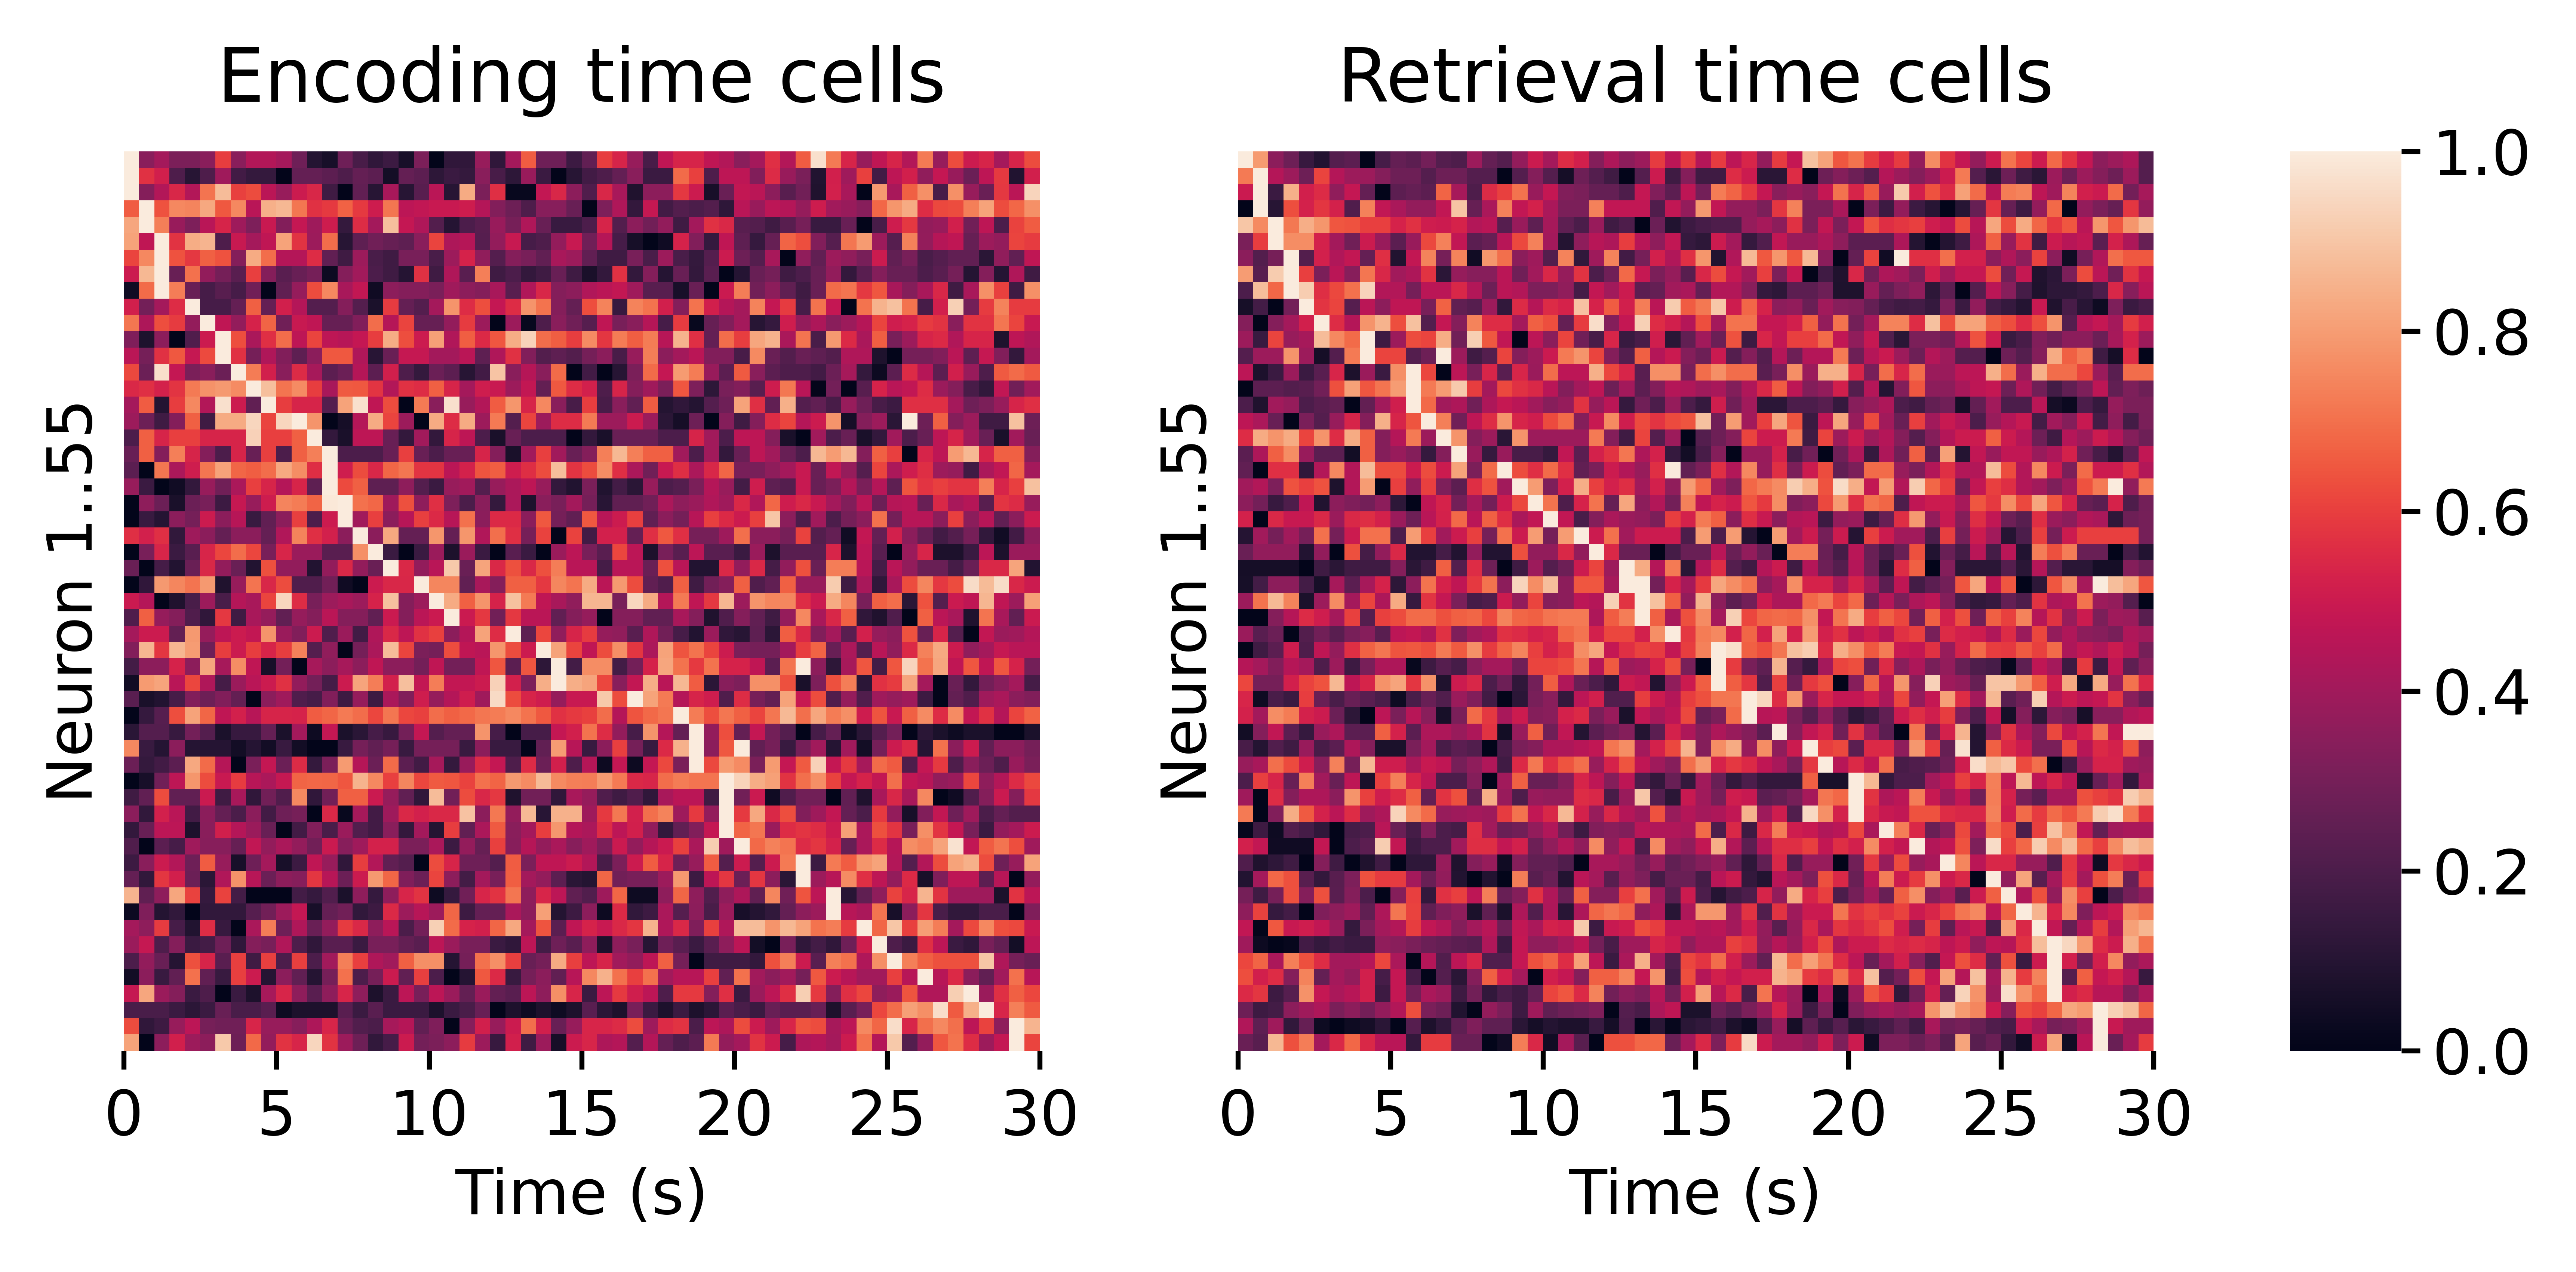

In [8]:
# === CONFIG ===
savefig = False
overwrite = False
grid_shp = (15, 37)
figsize = (colws['1'], colws['1'] * (grid_shp[0] / grid_shp[1]))
dpi = 1200
bins = 60
time_bin_width_sec = 0.5  # seconds per bin in combined PSTH

testvars = ['time', 'gameState:time', 'time:place']
# testvars = ['place', 'gameState:place']
moving_avg = None  # Set to None to disable

game_states = ['Encoding', 'Retrieval']
roi_filter = ['MTL']#,'MTL']#,'PFC','TPC'] #['HPC', 'MTL'] # ['HPC','MTL','PFC','TPC'] used roi=4 in spike_preproc

# === Get unique neurons that are significant in any of the testvars ===
neurons_of_interest = set()
for testvar in testvars:
    neurons_of_interest.update(sig_cells[testvar])
    
# Use ROI info in mod_pairs to filter general regions using those defined in roi_filter
filtered_mod_pairs = mod_pairs[mod_pairs['roi_gen'].isin(roi_filter)]
neurons_in_filtered_rois = set(filtered_mod_pairs['subj_sess_unit'].unique())
neurons_of_interest = neurons_of_interest.intersection(neurons_in_filtered_rois)

# === BUILD spike matrix ===
spikes_by_time = od({gs: [] for gs in game_states})
neuron_order = od({gs: [] for gs in game_states})  # track the order of neurons
sorted_neuron_lists = {}  # To store sorted neuron names for each game_state

for game_state in game_states:
    for neuron in neurons_of_interest:
        try:
            spike_mat = get_spike_mat_unsmoothed(neuron, game_state,proj_dir = "/data7/goldmine/")
            if spike_mat is not None:
                combined = _combine_time_bins(spike_mat, bins=bins)
                if combined is not None:
                    spikes_by_time[game_state].append(combined)
                    neuron_order[game_state].append(neuron)  # track order
        except Exception as e:
            print(f"Skipping {neuron} for {game_state}: {e}")

for gs in game_states:
    spikes_by_time[gs] = np.array(spikes_by_time[gs])

# === PLOT ===
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [
    plt.subplot2grid(grid_shp, (0, 0), rowspan=grid_shp[0], colspan=15),
    plt.subplot2grid(grid_shp, (0, 18), rowspan=grid_shp[0], colspan=15),
    plt.subplot2grid(grid_shp, (0, 35), rowspan=grid_shp[0], colspan=2),
]
ax = np.ravel(ax)

font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}
ax_titles = {'Encoding': 'Encoding time cells', 'Retrieval': 'Retrieval time cells'}
n_neurons = []

for i, game_state in enumerate(game_states):
    fr_raw = spikes_by_time[game_state]  # shape: neurons x time
    neuron_ids = np.array(neuron_order[game_state]) # assumes spikes_by_time order matches this
    
    if moving_avg and moving_avg > 1:
        kernel = np.ones(moving_avg) / moving_avg
        # Smooth before normalization
        fr_smooth = np.array([
            np.convolve(row, kernel, mode='same') for row in fr_raw
        ])
    else:
        fr_smooth = fr_raw

    # Normalize after smoothing
    fr_norm = minmax_scale(fr_smooth, axis=1)

    # Find peak bin for each neuron
    peak_bins = np.argmax(fr_norm, axis=1)
    xsort = np.argsort(peak_bins)
    sorted_peak_bins = peak_bins[xsort]

    fr_mat = fr_norm[xsort, :]
    n_neurons.append(fr_mat.shape[0])

    # keep sorted neuron names
    sorted_neurons = neuron_ids[xsort]

    # Convert peak bin index to seconds
    sorted_peak_times_sec = sorted_peak_bins * time_bin_width_sec

    # Save neuron names and peak times together
    sorted_neuron_lists[game_state] = [
        {
            "neuron": neuron_name,
            "peak_time_sec": float(peak_time)
        }
        for neuron_name, peak_time in zip(sorted_neurons, sorted_peak_times_sec)
    ]

    # Plot
    n_bins = fr_mat.shape[1]
    xticks = np.arange(0, n_bins + 1, 10)
    xticklabels = (xticks * time_bin_width_sec).astype(int)

    add_cbar = i == len(ax) - 2

    ax[i] = sns.heatmap(fr_mat, ax=ax[i], vmin=0, vmax=1, cmap='rocket',
                        square=False, cbar=add_cbar, cbar_ax=ax[i + 1] if add_cbar else None)

    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[i].tick_params(axis='y', which='both', length=0, pad=3)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
    ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[i].set_yticks([])
    ax[i].set_ylabel(f'Neuron 1..{n_neurons[-1]}', fontsize=font['label'], labelpad=3)
    ax[i].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])

    if add_cbar:
        cbar = ax[i].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=2)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])


# === SAVE ===
if savefig:
    label = '-'.join([tv.replace(':', '') for tv in testvars])
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       f'navigation_time_cells-{label}-encoding-{n_neurons[0]}-retrieval-{n_neurons[1]}-total-{len(neurons_of_interest)}.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show();


# Let's look for replay in Delay2 of encoding time cells

In [9]:
replay_window = 30 # time in ms to look for spike pairs

print("Encoding sorted neurons:", sorted_neuron_lists['Encoding'][:5])
print("Retrieval sorted neurons:", sorted_neuron_lists['Retrieval'][:5])
peak_times_encoding = np.array([d['peak_time_sec'] for d in sorted_neuron_lists['Encoding']])
peak_neurons_encoding = np.array([d['neuron'] for d in sorted_neuron_lists['Encoding']])
peak_times_encoding
peak_neurons_encoding

Encoding sorted neurons: [{'neuron': 'U526_ses0-12-1', 'peak_time_sec': 0.0}, {'neuron': 'U536_ses0-66-1', 'peak_time_sec': 0.0}, {'neuron': 'U527_ses0-41-1', 'peak_time_sec': 0.0}, {'neuron': 'U532_ses0-10-1', 'peak_time_sec': 0.5}, {'neuron': 'U530_ses0-45-1', 'peak_time_sec': 0.5}]
Retrieval sorted neurons: [{'neuron': 'U536_ses0-66-1', 'peak_time_sec': 0.0}, {'neuron': 'U539_ses0-50-1', 'peak_time_sec': 0.5}, {'neuron': 'U530_ses0-45-1', 'peak_time_sec': 0.5}, {'neuron': 'U518_ses0-31-1', 'peak_time_sec': 0.5}, {'neuron': 'U532_ses0-10-1', 'peak_time_sec': 1.0}]


array([ 0. ,  0. ,  0. ,  0.5,  0.5,  1. ,  1. ,  1. ,  1. ,  2. ,  2.5,
        3. ,  3. ,  3.5,  4. ,  4.5,  5.5,  6. ,  6.5,  6.5,  6.5,  7. ,
        7. ,  7.5,  8. ,  8.5,  9.5, 10. , 10.5, 12.5, 13.5, 14. , 14. ,
       16.5, 18. , 18.5, 18.5, 18.5, 19.5, 19.5, 19.5, 19.5, 20. , 22. ,
       22. , 23. , 23. , 24. , 24.5, 25. , 26. , 27.5, 28. , 29. , 29. ])

array(['U526_ses0-12-1', 'U536_ses0-66-1', 'U527_ses0-41-1',
       'U532_ses0-10-1', 'U530_ses0-45-1', 'U527_ses0-17-2',
       'U527_ses0-44-2', 'U530_ses0-71-1', 'U539_ses0-55-1',
       'U530_ses0-70-1', 'U530_ses0-7-4', 'U526_ses0-14-1',
       'U530_ses0-7-3', 'U527_ses0-44-4', 'U530_ses1-42-1',
       'U527_ses0-20-1', 'U527_ses0-44-1', 'U527_ses0-44-3',
       'U530_ses0-45-2', 'U518_ses0-27-1', 'U530_ses0-46-2',
       'U536_ses0-68-1', 'U530_ses0-72-1', 'U527_ses0-43-1',
       'U530_ses0-66-2', 'U518_ses1-41-1', 'U536_ses0-72-2',
       'U530_ses1-46-2', 'U530_ses1-41-1', 'U521_ses0-19-2',
       'U518_ses1-43-1', 'U539_ses0-14-2', 'U537_ses0-39-1',
       'U530_ses0-3-2', 'U536_ses0-20-1', 'U532_ses0-10-2',
       'U539_ses0-50-1', 'U532_ses0-15-1', 'U518_ses0-42-1',
       'U521_ses0-21-3', 'U532_ses0-12-1', 'U539_ses0-11-2',
       'U518_ses1-4-4', 'U518_ses0-32-1', 'U521_ses0-18-1',
       'U518_ses0-28-1', 'U518_ses1-43-3', 'U530_ses0-42-1',
       'U532_ses0-9-1', 'U53

In [10]:
# get the pairs of time cells with peaks in order of encoding fields

peak_neurons_encoding = np.array([d['neuron'] for d in sorted_neuron_lists['Encoding']])
peak_times_encoding = np.array([d['peak_time_sec'] for d in sorted_neuron_lists['Encoding']])

# 1. Group neurons by session
sessions = np.array([n.split('-')[0] for n in peak_neurons_encoding])
session_neurons = defaultdict(list)

for neuron, peak_time, session in zip(peak_neurons_encoding, peak_times_encoding, sessions):
    session_neurons[session].append((neuron, peak_time))

# 2. Build neuron pairs
all_pairs = []

for session, neuron_list in session_neurons.items():
    neuron_list_sorted = sorted(neuron_list, key=lambda x: x[1])

    for i in range(len(neuron_list_sorted)):
        n1, t1 = neuron_list_sorted[i]
        for j in range(i+1, len(neuron_list_sorted)):
            n2, t2 = neuron_list_sorted[j]
            if t2 > t1:
                all_pairs.append([n1, n2])
            elif t2 == t1:
                continue


In [91]:
all_pairs

[['U526_ses0-45-1', 'U526_ses0-44-1'],
 ['U526_ses0-45-1', 'U526_ses0-41-1'],
 ['U526_ses0-44-1', 'U526_ses0-41-1'],
 ['U540_ses0-4-3', 'U540_ses0-6-3'],
 ['U532_ses0-5-8', 'U532_ses0-5-3'],
 ['U532_ses0-5-8', 'U532_ses0-4-3'],
 ['U532_ses0-5-8', 'U532_ses0-4-1'],
 ['U532_ses0-5-8', 'U532_ses0-5-1'],
 ['U532_ses0-5-8', 'U532_ses0-3-3'],
 ['U532_ses0-5-8', 'U532_ses0-5-7'],
 ['U532_ses0-5-8', 'U532_ses0-2-1'],
 ['U532_ses0-3-1', 'U532_ses0-5-3'],
 ['U532_ses0-3-1', 'U532_ses0-4-3'],
 ['U532_ses0-3-1', 'U532_ses0-4-1'],
 ['U532_ses0-3-1', 'U532_ses0-5-1'],
 ['U532_ses0-3-1', 'U532_ses0-3-3'],
 ['U532_ses0-3-1', 'U532_ses0-5-7'],
 ['U532_ses0-3-1', 'U532_ses0-2-1'],
 ['U532_ses0-5-3', 'U532_ses0-4-3'],
 ['U532_ses0-5-3', 'U532_ses0-4-1'],
 ['U532_ses0-5-3', 'U532_ses0-5-1'],
 ['U532_ses0-5-3', 'U532_ses0-3-3'],
 ['U532_ses0-5-3', 'U532_ses0-5-7'],
 ['U532_ses0-5-3', 'U532_ses0-2-1'],
 ['U532_ses0-4-3', 'U532_ses0-4-1'],
 ['U532_ses0-4-3', 'U532_ses0-5-1'],
 ['U532_ses0-4-3', 'U532_ses0-3-

In [11]:
# Map neurons to sessions
neuron_to_session = {
    neuron: neuron.split('-')[0]
    for neuron in peak_neurons_encoding
}

replay_by_session_delay1 = []
replay_by_session_delay2 = []

for subj_sess in session_neurons.keys(): # this does a unique on the keys already
    
    # need the events to get the delay start/ends
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir)
    es = event_spikes.event_spikes
    
    # Find all pairs belonging to this session
    pairs_in_session = [
        (n1, n2)
        for n1, n2 in all_pairs
        if n1.startswith(subj_sess) and n2.startswith(subj_sess)
    ]
    
    for delay_name in ["Delay1", "Delay2"]:
    
        replay_counts = np.zeros(4, dtype=int)

        for n1, n2 in pairs_in_session:
            # try:
                # Load Delay2 spike arrays for both neurons
                CSC, unit = parse_neuron_name(n1, subj_sess)
                spikes1 = load_spikes_from_pkl(subj_sess, CSC, unit)
                CSC, unit = parse_neuron_name(n2, subj_sess)
                spikes2 = load_spikes_from_pkl(subj_sess, CSC, unit)          

                if spikes1 is not None and spikes2 is not None: # now have spike arrays for both neurons

                    # go through every delay period and find its start and end
                    for t in np.unique(es.trial):
                        delay_by_trial = es.query("gameState == @delay_name and trial == @t")
                        delay_start = np.min(delay_by_trial.start_time)
                        delay_end = np.max(delay_by_trial.stop_time)  

                        # find spikes in delay
                        delay_spikes1 = spikes1.spike_times[(spikes1.spike_times>delay_start) & (spikes1.spike_times<delay_end)]
                        delay_spikes2 = spikes2.spike_times[(spikes2.spike_times>delay_start) & (spikes2.spike_times<delay_end)]

                        for spike in delay_spikes1:
                            replay_counts[0] += 1
                            mask = (delay_spikes2 > spike) & (delay_spikes2 <= spike + replay_window)
                            if mask.any():
                                replay_counts[1] += 1

                        for spike in delay_spikes2:
                            replay_counts[2] += 1
                            mask = (delay_spikes1 > spike) & (delay_spikes1 <= spike + replay_window)
                            if mask.any():
                                replay_counts[3] += 1                      

        # Save results for the delay period
        if delay_name == "Delay1":
            replay_by_session_delay1.append(replay_counts)
        else:
            replay_by_session_delay2.append(replay_counts)

            # except Exception as e:
            #     print(f"Skipping pair ({n1}, {n2}) in {subj_sess} due to error: {e}")


Loading saved EventSpikes for U526_ses0
Loading saved EventSpikes for U536_ses0
Loading saved EventSpikes for U527_ses0
Loading saved EventSpikes for U532_ses0
Loading saved EventSpikes for U530_ses0
Loading saved EventSpikes for U539_ses0
Loading saved EventSpikes for U530_ses1
Loading saved EventSpikes for U518_ses0
Loading saved EventSpikes for U518_ses1
Loading saved EventSpikes for U521_ses0
Loading saved EventSpikes for U537_ses0


In [12]:
# define if you want to look at delay1 or delay2
replay_summary_by_session = replay_by_session_delay2 # replay_by_session_delay2

replay_summary_by_session = np.array(replay_summary_by_session)
print('Forward replay ('+str(replay_window)+' ms window):')
replay_summary_by_session[:,1]/replay_summary_by_session[:,0]
print('out of:')
print(replay_summary_by_session[:,0])
print('')
print('Reverse replay ('+str(replay_window)+' ms window):')
replay_summary_by_session[:,3]/replay_summary_by_session[:,2]
print('out of:')
print(replay_summary_by_session[:,2])

Forward replay (30 ms window):


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


array([0.04143389, 0.11165049, 0.0405809 , 0.04637437, 0.06951825,
       0.04976201, 0.03703994, 0.0929507 , 0.02971474, 0.09457442,
              nan])

out of:
[ 2148 14832 26786 13046 45542  2311 25513 40387  2524  4018     0]

Reverse replay (30 ms window):


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


array([0.04733333, 0.08647541, 0.08711624, 0.11661983, 0.05050311,
       0.03485086, 0.53046304, 0.12509267, 0.03038674, 0.08364226,
              nan])

out of:
[ 1500 19520 11433  4982 67679  3185  1231 29674  2534  4316     0]


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


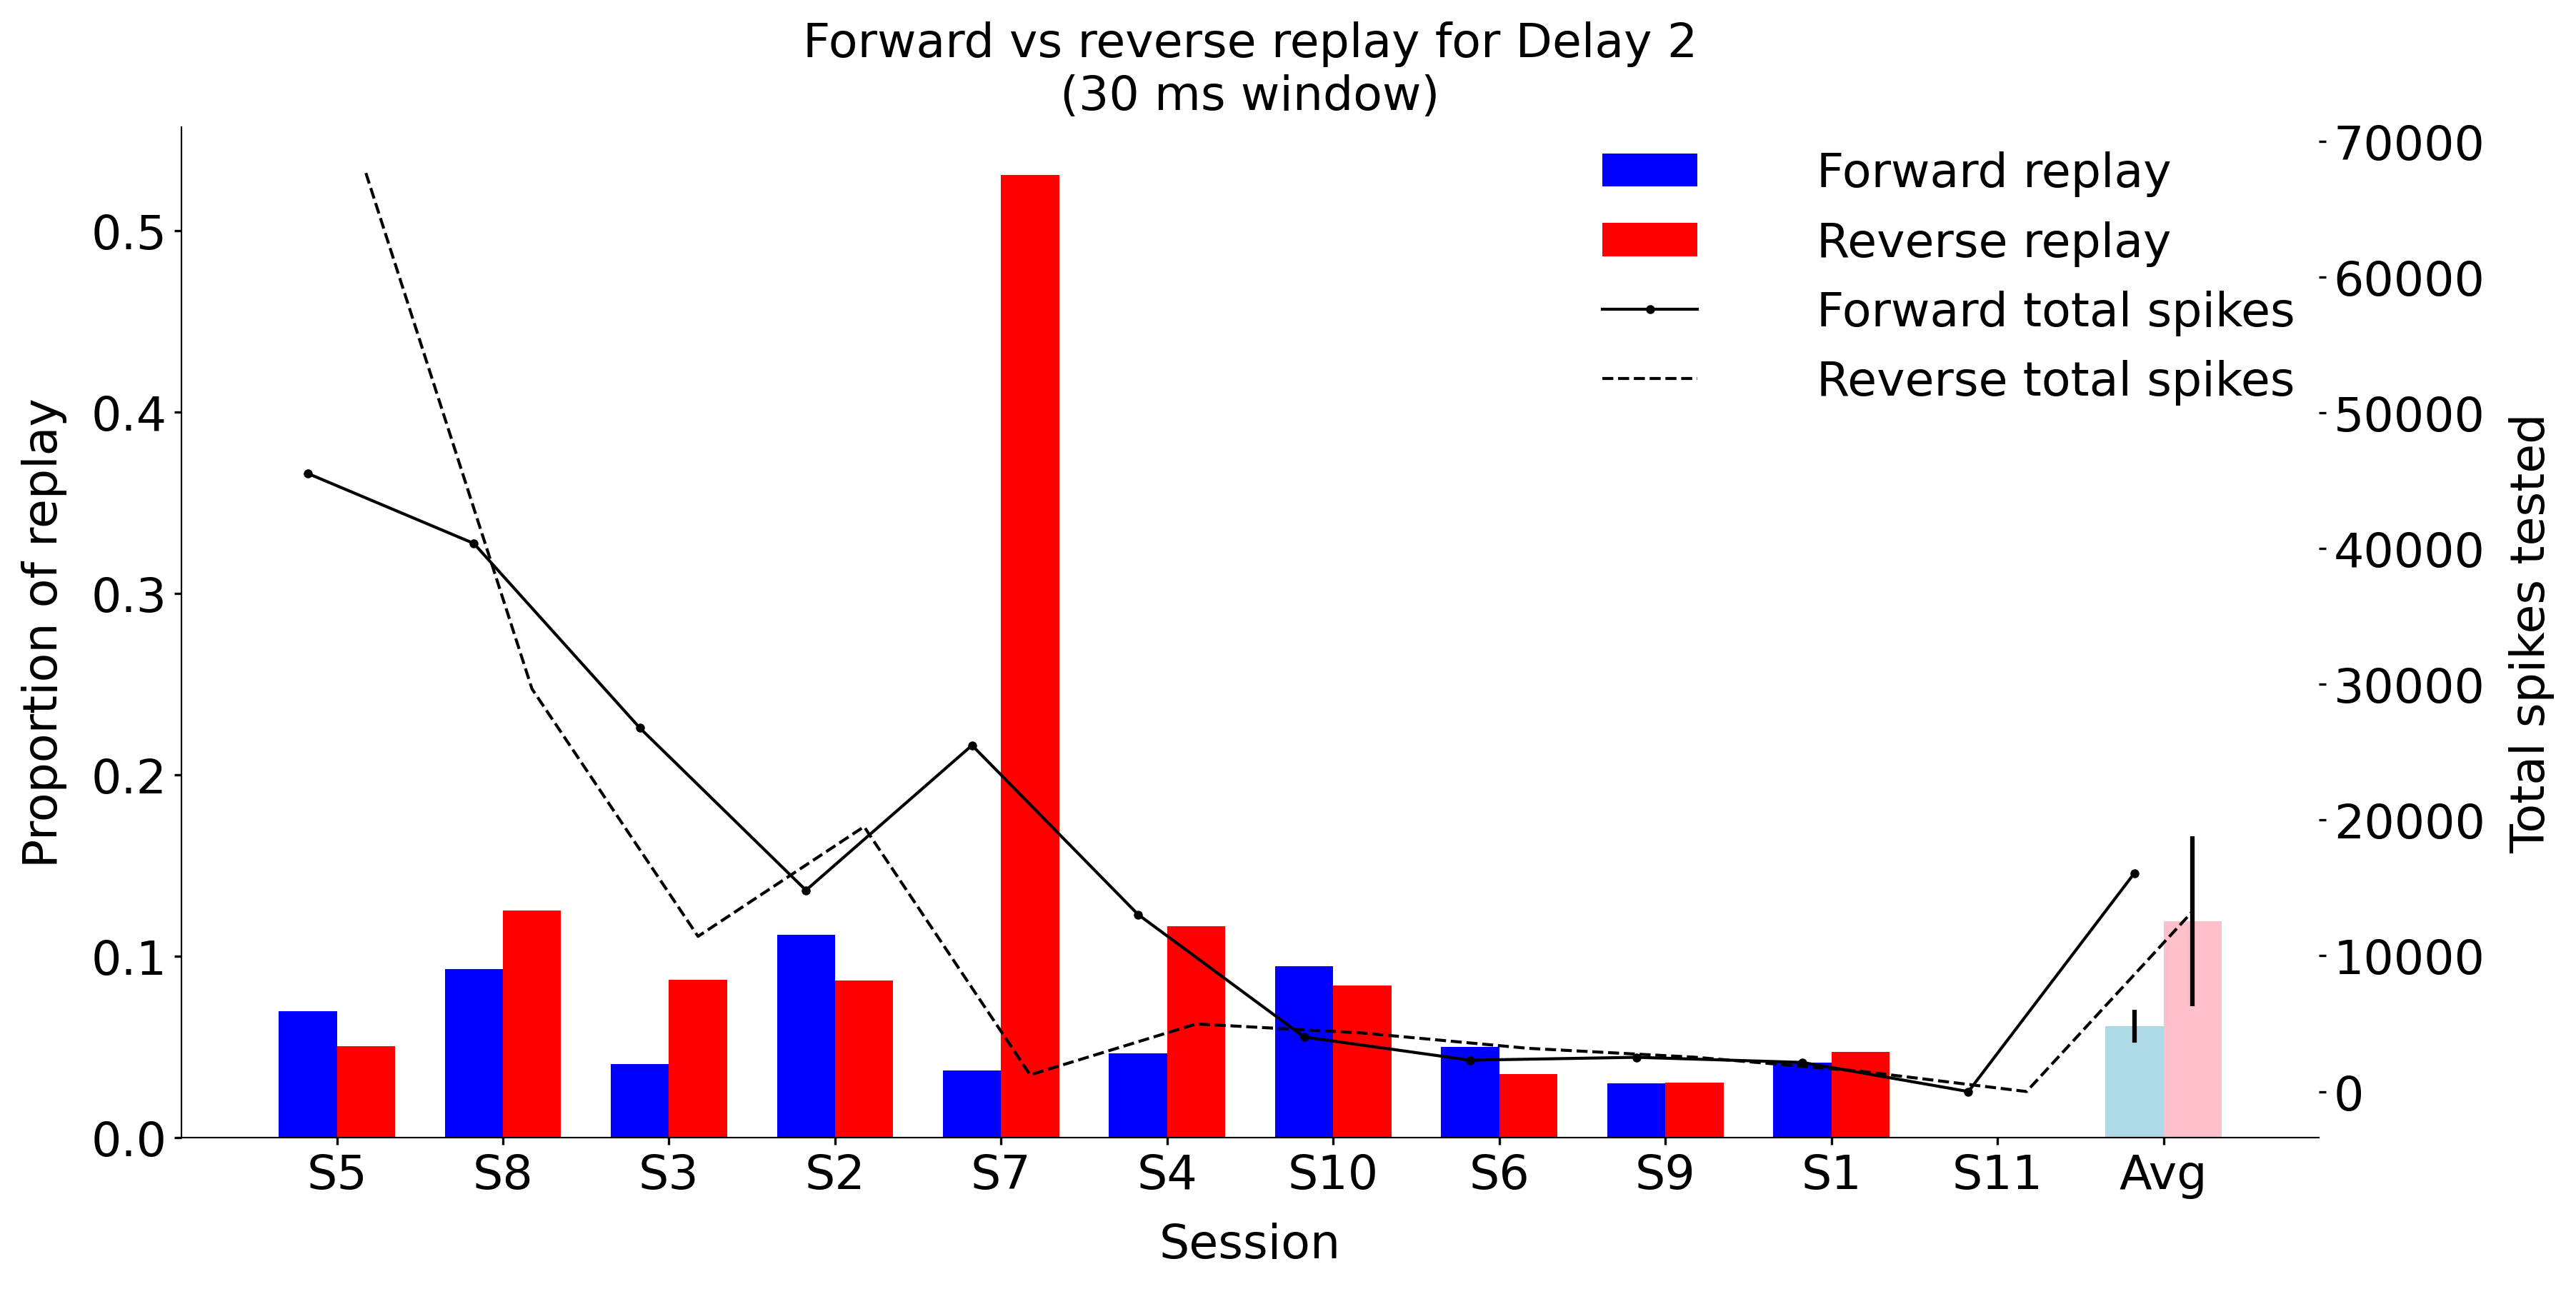

In [13]:
# Plot forward and reverse replays

forward_props = replay_summary_by_session[:,1]/replay_summary_by_session[:,0]
reverse_props = replay_summary_by_session[:,3]/replay_summary_by_session[:,2]
forward_outof = replay_summary_by_session[:,0]
reverse_outof = replay_summary_by_session[:,2]

# Compute total spikes tested for sorting
total_outof = forward_outof + reverse_outof
sort_idx = np.argsort(-total_outof)  # descending sort

# Sort all arrays
forward_props_sorted = forward_props[sort_idx]
reverse_props_sorted = reverse_props[sort_idx]
forward_outof_sorted = forward_outof[sort_idx]
reverse_outof_sorted = reverse_outof[sort_idx]

# Compute averages and SE
n_sessions = len(forward_props_sorted)
forward_mean = np.nanmean(forward_props_sorted)
forward_se = np.nanstd(forward_props_sorted, ddof=1) / np.sqrt(np.sum(~np.isnan(forward_props_sorted)))

reverse_mean = np.nanmean(reverse_props_sorted)
reverse_se = np.nanstd(reverse_props_sorted, ddof=1) / np.sqrt(np.sum(~np.isnan(reverse_props_sorted)))

# Add averages to data
forward_props_all = np.append(forward_props_sorted, 0 if np.isnan(forward_mean) else forward_mean)
reverse_props_all = np.append(reverse_props_sorted, 0 if np.isnan(reverse_mean) else reverse_mean)

forward_outof_all = np.append(forward_outof_sorted, forward_outof_sorted.mean())
reverse_outof_all = np.append(reverse_outof_sorted, reverse_outof_sorted.mean())

# X positions
sessions = np.arange(len(forward_props_sorted))
sessions_with_avg = np.append(sessions, sessions[-1] + 1)
bar_width = 0.35

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plots
ax1.bar(
    sessions_with_avg - bar_width/2, 
    forward_props_all, 
    bar_width, 
    label='Forward replay',
    color=['blue'] * n_sessions + ['lightblue']
)

ax1.bar(
    sessions_with_avg + bar_width/2, 
    reverse_props_all, 
    bar_width, 
    label='Reverse replay',
    color=['red'] * n_sessions + ['pink']
)

# Add SE error bars on average bars only
ax1.errorbar(
    sessions_with_avg[-1] - bar_width/2,
    forward_mean,
    yerr=forward_se,
    fmt='none',
    ecolor='black',
    capsize=5,
    linewidth=1.5
)

ax1.errorbar(
    sessions_with_avg[-1] + bar_width/2,
    reverse_mean,
    yerr=reverse_se,
    fmt='none',
    ecolor='black',
    capsize=5,
    linewidth=1.5
)

# Labels
ax1.set_xlabel('Session', fontsize=16)
ax1.set_ylabel('Proportion of replay', fontsize=16)
if (replay_summary_by_session == replay_by_session_delay1).all():
    delay_name = 'Delay 1'
else:
    delay_name = 'Delay 2'
ax1.set_title(f'Forward vs reverse replay for {delay_name}\n({replay_window} ms window)', fontsize=16)
ax1.set_xticks(sessions_with_avg)
ax1.set_xticklabels(
    [f'S{sort_idx[i]+1}' for i in range(n_sessions)] + ['Avg'],
    fontsize=16
)
ax1.tick_params(axis='y', labelsize=16)

# Right axis
ax2 = ax1.twinx()
ax2.plot(
    sessions_with_avg - bar_width/2,
    forward_outof_all,
    color='black',
    marker='o',
    label='Forward total spikes'
)

ax2.plot(
    sessions_with_avg + bar_width/2,
    reverse_outof_all,
    color='black',
    linestyle='--',
    marker='x',
    label='Reverse total spikes'
)

ax2.set_ylabel('Total spikes tested', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
# ax2.set_yscale('log')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=16)

plt.tight_layout()
plt.show();

# Permutation test to see baseline level of replay

Loading saved EventSpikes for U526_ses0
--Call--
> /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> /tmp/ipykernel_180258/3942574366.py(52)<module>()
     51                     # Apply circular shift
---> 52                     import ipdb; ipdb.set_trace()
     53                     shifted_spikes1 = (spikes1.spike_times + shift1) % spikes1.sess_stop_time



ipdb>  l


     47                     # Generate random circular shifts
     48                     shift1 = np.random.uniform(0, spikes1.sess_stop_time)
     49                     shift2 = np.random.uniform(0, spikes2.sess_stop_time)
     50 
     51                     # Apply circular shift
---> 52                     import ipdb; ipdb.set_trace()
     53                     shifted_spikes1 = (spikes1.spike_times + shift1) % spikes1.sess_stop_time
     54                     shifted_spikes2 = (spikes2.spike_times + shift2) % spikes2.sess_stop_time
     55 
     56                     # Loop over all trials
     57                     for t in np.unique(es.trial):



ipdb>  shift1


1902254.5837643633


ipdb>  shift2


3572290.928753769


ipdb>  shifted_spikes1 = (spikes1.spike_times + shift1) % spikes1.sess_stop_time
ipdb>  shifted_spikes1[0:20]


array([1903022.58376436, 1906265.58376436, 1906272.58376436,
       1907845.58376436, 1907857.58376436, 1907876.58376436,
       1907905.58376436, 1908079.58376436, 1908708.58376436,
       1908826.58376436, 1909876.58376436, 1909894.58376436,
       1909931.58376436, 1912487.58376436, 1912516.58376436,
       1912825.58376436, 1913402.58376436, 1913455.58376436,
       1913553.58376436, 1913683.58376436])


ipdb>  shifted_spikes[-20:]


*** NameError: name 'shifted_spikes' is not defined


ipdb>  shifted_spikes1[-20:]


array([1880782.58376436, 1884408.58376436, 1885577.58376436,
       1886718.58376436, 1887797.58376436, 1887880.58376436,
       1887897.58376436, 1888542.58376436, 1890081.58376436,
       1892922.58376436, 1893542.58376436, 1893657.58376436,
       1894157.58376436, 1894868.58376436, 1895930.58376436,
       1897627.58376436, 1897637.58376436, 1898033.58376436,
       1901809.58376436, 1901820.58376436])


ipdb>  plt.plot(shifted_spikes1); plt.show()


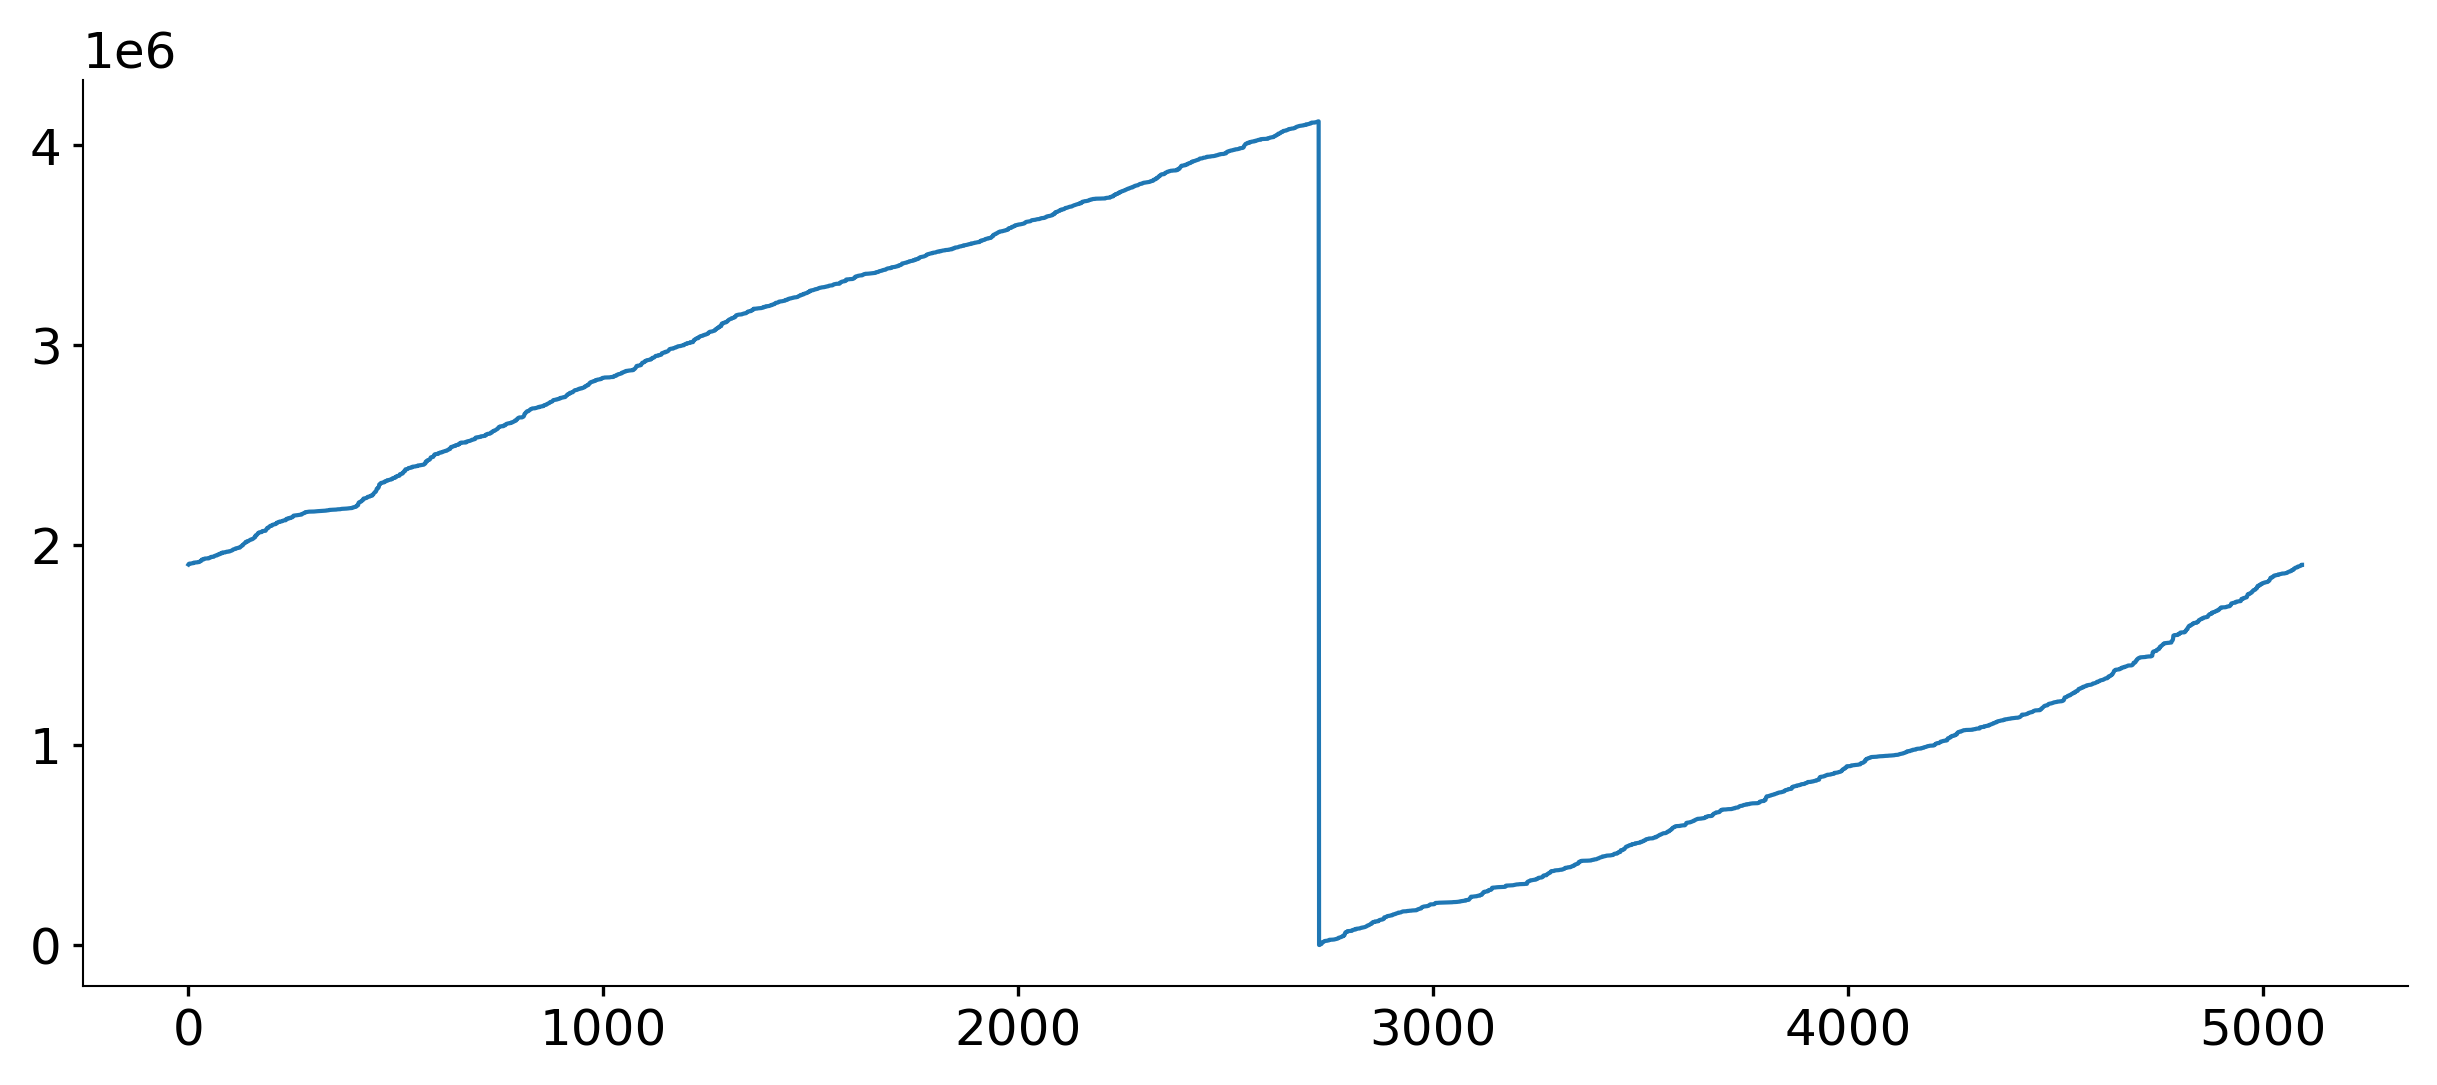

In [ ]:
permutations = 10

# Map neurons to sessions
neuron_to_session = {
    neuron: neuron.split('-')[0]
    for neuron in peak_neurons_encoding
}

n_sessions = len(session_neurons.keys())

# Allocate 3D arrays:
# shape = (n_permutations, n_sessions, 4)
replay_by_session_delay1 = np.zeros((permutations, n_sessions, 4), dtype=int)
replay_by_session_delay2 = np.zeros((permutations, n_sessions, 4), dtype=int)

# Iterate sessions
for session_idx, subj_sess in enumerate(session_neurons.keys()):
    
    # load events
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir)
    es = event_spikes.event_spikes

    # Find all pairs belonging to this session
    pairs_in_session = [
        (n1, n2)
        for n1, n2 in all_pairs
        if n1.startswith(subj_sess) and n2.startswith(subj_sess)
    ]
    
    for delay_name in ["Delay1", "Delay2"]:
        
        for perm in range(permutations):
            
            # Initialize array for this permutation
            replay_counts = np.zeros(4, dtype=int)
            
            for n1, n2 in pairs_in_session:
                
                # Load spikes for both neurons
                CSC, unit = parse_neuron_name(n1, subj_sess)
                spikes1 = load_spikes_from_pkl(subj_sess, CSC, unit)
                CSC, unit = parse_neuron_name(n2, subj_sess)
                spikes2 = load_spikes_from_pkl(subj_sess, CSC, unit)
                
                if spikes1 is not None and spikes2 is not None:
                    
                    # Generate random circular shifts
                    shift1 = np.random.uniform(0, spikes1.sess_stop_time)
                    shift2 = np.random.uniform(0, spikes2.sess_stop_time)
                    
                    # Apply circular shift
                    import ipdb; ipdb.set_trace()
                    shifted_spikes1 = (spikes1.spike_times + shift1) % spikes1.sess_stop_time
                    shifted_spikes2 = (spikes2.spike_times + shift2) % spikes2.sess_stop_time
                    
                    # Loop over all trials
                    for t in np.unique(es.trial):
                        delay_by_trial = es.query("gameState == @delay_name and trial == @t")
                        if delay_by_trial.empty:
                            continue
                        
                        delay_start = np.min(delay_by_trial.start_time)
                        delay_end = np.max(delay_by_trial.stop_time)
                        
                        # find shifted spikes in delay
                        delay_spikes1 = shifted_spikes1[
                            (shifted_spikes1 > delay_start) &
                            (shifted_spikes1 < delay_end)
                        ]
                        delay_spikes2 = shifted_spikes2[
                            (shifted_spikes2 > delay_start) &
                            (shifted_spikes2 < delay_end)
                        ]
                        
                        for spike in delay_spikes1:
                            replay_counts[0] += 1
                            mask = (delay_spikes2 > spike) & (delay_spikes2 <= spike + replay_window)
                            if mask.any():
                                replay_counts[1] += 1
                                
                        for spike in delay_spikes2:
                            replay_counts[2] += 1
                            mask = (delay_spikes1 > spike) & (delay_spikes1 <= spike + replay_window)
                            if mask.any():
                                replay_counts[3] += 1
            
            # Save result for this permutation and session
            if delay_name == "Delay1":
                replay_by_session_delay1[perm, session_idx, :] = replay_counts
            else:
                replay_by_session_delay2[perm, session_idx, :] = replay_counts


# Single-neuron time and place plots

In [705]:
reload(time_cell_plots)

<module 'time_cells.time_cell_plots' from '/home1/dscho/code/projects/time_cells/time_cell_plots.py'>

In [786]:
# Load the data.
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
spike_mat = {game_state: event_spikes.get_spike_mat(neuron, game_state).values * 2
             for game_state in game_states} # trial x time_bin

In [1173]:
subj_sess_unit = 'U527_ses0-58-2'

filename = op.join(proj_dir, 'analysis', 'time_fields',
                   '{}-Encoding_Retrieval-smooth3-1000perm-zthresh1.96-max_skips1-time_fields.pkl'.format(subj_sess_unit))
output = dio.open_pickle(filename)
time_fields = output['time_fields']
z_frs = output['z_frs']

print('time_fields:', time_fields.shape)

time_fields: (8, 8)


In [1203]:
subj_sess_unit = 'U527_ses0-58-2'
mod_pairs.query("(subj_sess_unit=='{}') & (sig==True)".format(subj_sess_unit))

In [1202]:
time_fields.query("(subj_sess_unit=='{}')".format(subj_sess_unit))

In [1201]:
ols_weights.query("(subj_sess_unit=='{}') & (model=='fullMax')".format(subj_sess_unit))#.sort_values('z_weight', ascending=False)

In [1171]:
testvar = 'gameState:time'

globstr = 'ls'
neurons = []
for subj_sess_unit in np.sort(list(y_scale.keys())):
    if subj_sess_unit in sig_cells[testvar]:
        neurons.append(subj_sess_unit)
        subj_sess = subj_sess_unit.split('-')[0]
        neuron = '-'.join(subj_sess_unit.split('-')[1:])
        globstr += ' {}-CSC{}-unit{}*{}_firing.png'.format(subj_sess, neuron.split('-')[0], neuron.split('-')[1], testvar)
    
print('{}/{} neurons'.format(len(neurons), len(y_scale)))
print(globstr)

12/15 neurons
ls U518_ses0-CSC73-unit1*gameState:time_firing.png U526_ses0-CSC14-unit2*gameState:time_firing.png U527_ses0-CSC44-unit2*gameState:time_firing.png U527_ses0-CSC44-unit4*gameState:time_firing.png U527_ses0-CSC58-unit2*gameState:time_firing.png U527_ses0-CSC9-unit1*gameState:time_firing.png U530_ses1-CSC42-unit1*gameState:time_firing.png U532_ses0-CSC21-unit2*gameState:time_firing.png U532_ses0-CSC24-unit2*gameState:time_firing.png U532_ses0-CSC4-unit1*gameState:time_firing.png U532_ses0-CSC5-unit8*gameState:time_firing.png U540_ses0-CSC26-unit1*gameState:time_firing.png


U527_ses0-44-4, REC


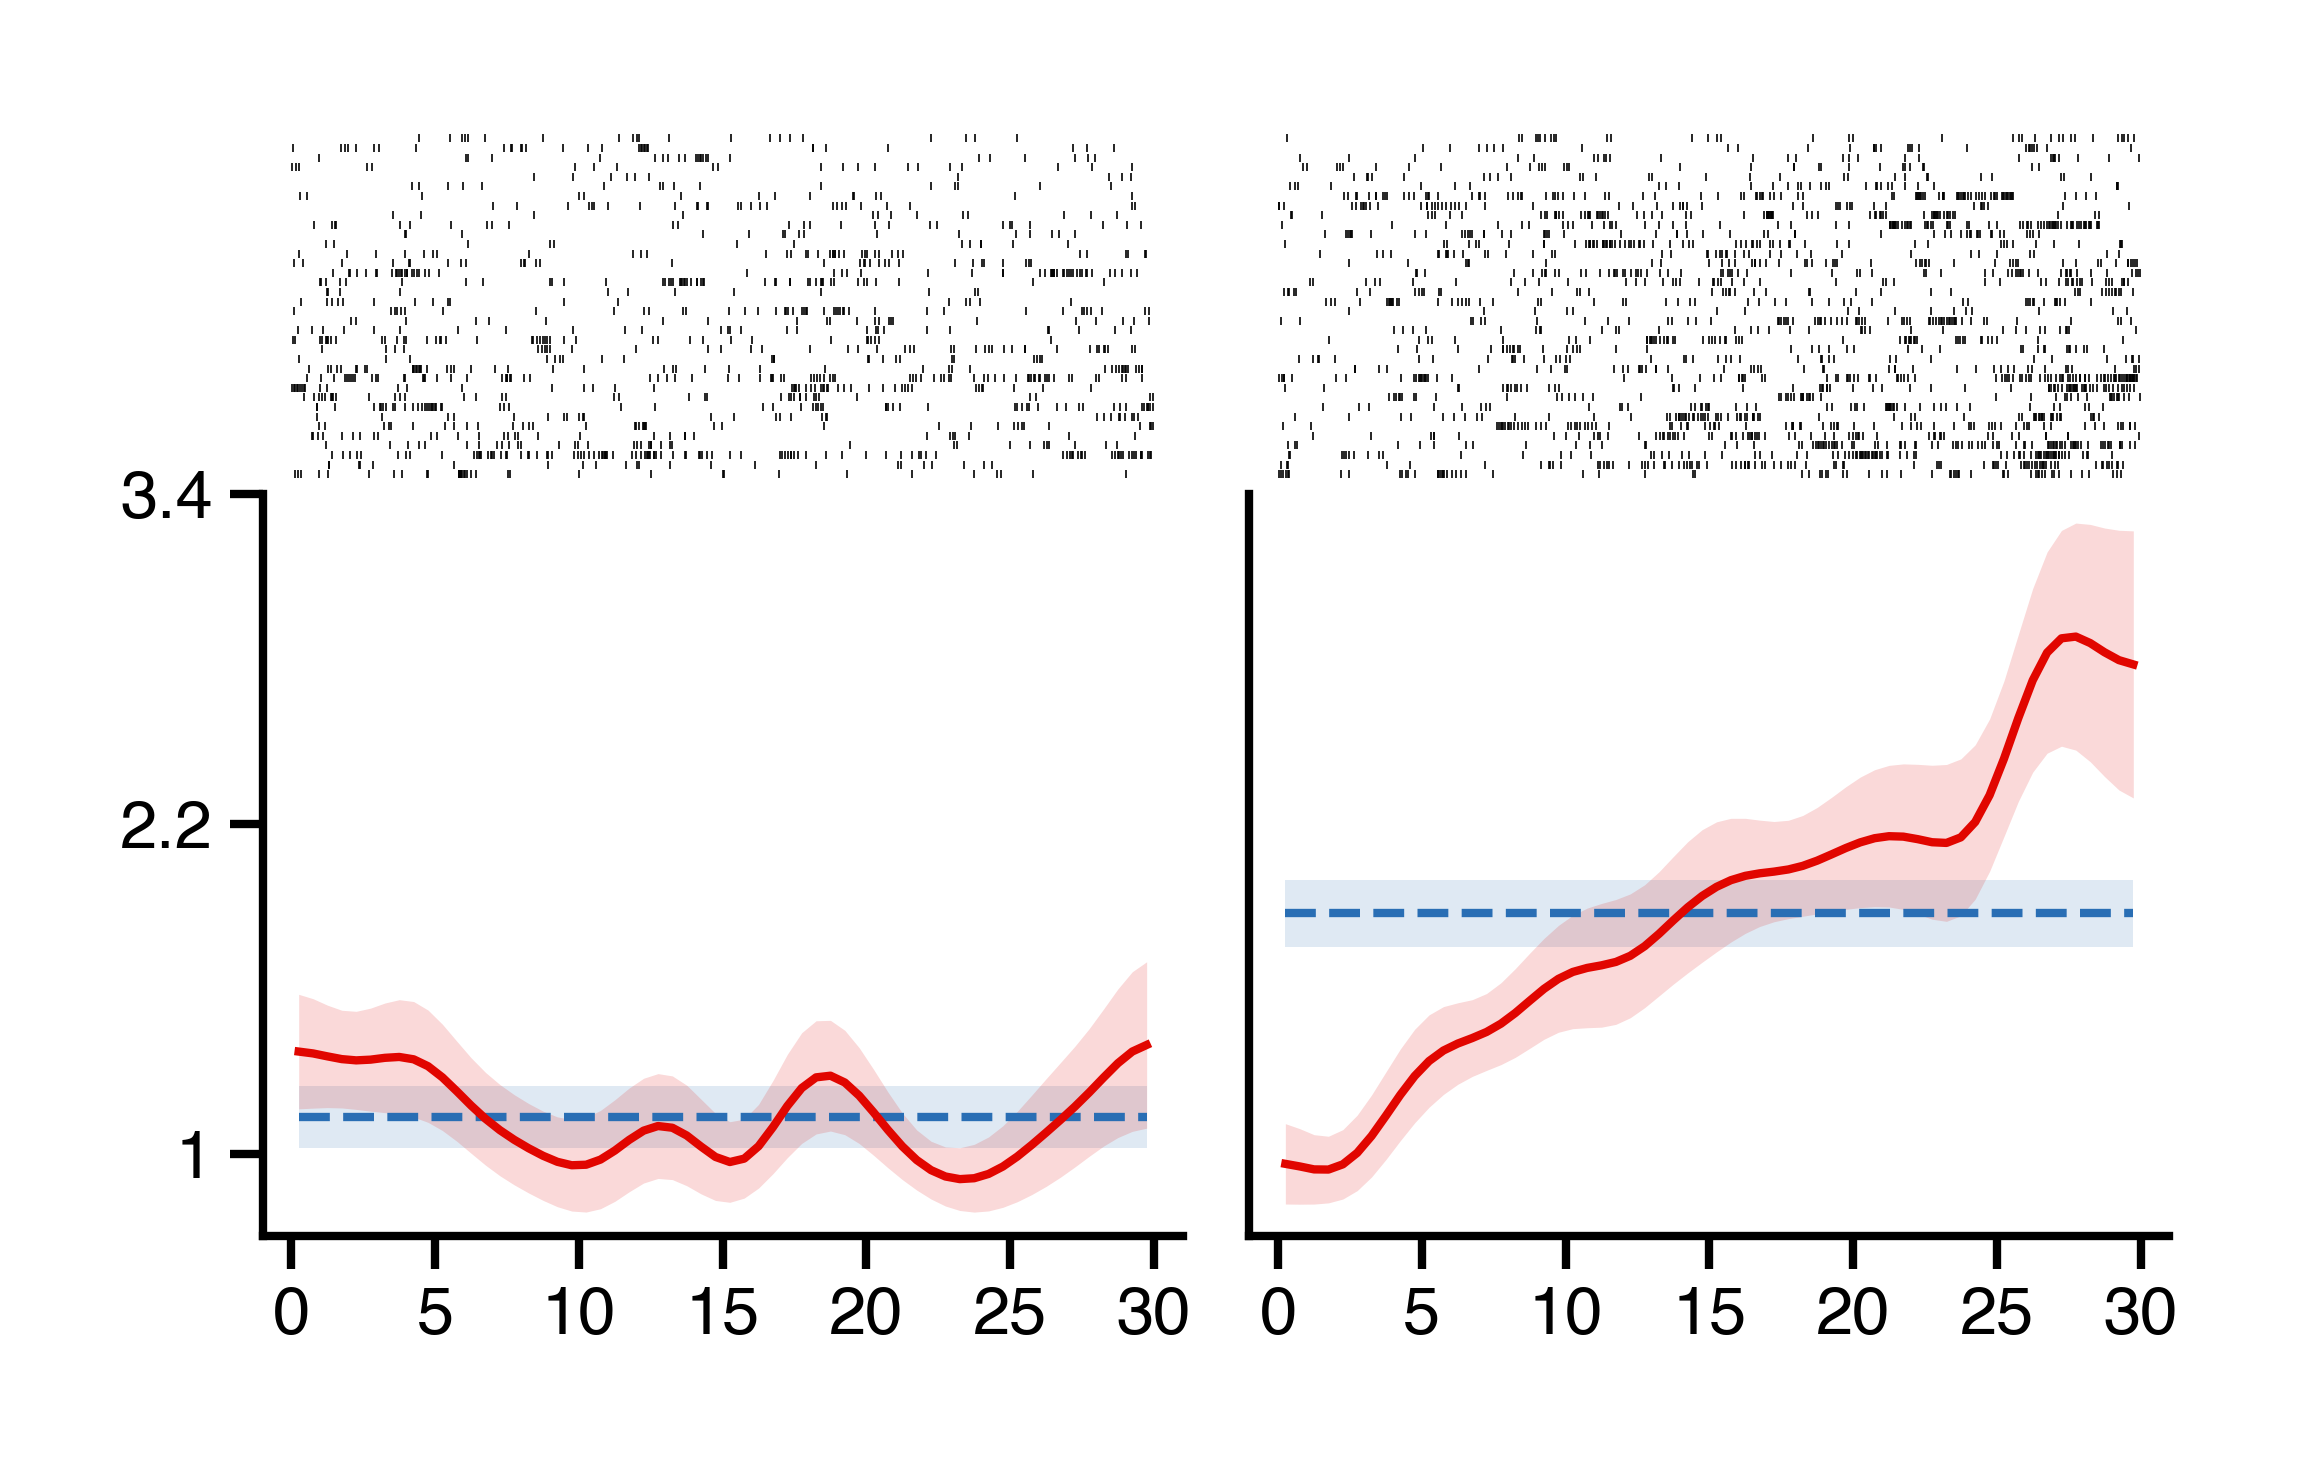

In [1164]:
# gameState      - 'U530_ses1-69-1'
# gameState:time - 'U527_ses0-44-2'
# place          - 'U540_ses0-20-1'
# time:place     - 'U536_ses0-68-1'
subj_sess_unit = ['U518_ses0-73-1', 'U532_ses0-5-8', 'U532_ses0-24-2', 'U532_ses0-21-2', 'U526_ses0-14-2',
                  'U540_ses0-26-1', 'U532_ses0-4-1', 'U530_ses1-42-1', 'U527_ses0-9-1', 'U527_ses0-44-4']
testvar = 'gameState:time'
savefig = 1
overwrite = 1
game_states = ['Encoding', 'Retrieval']
y_scale = {'U530_ses1-69-1': {'ymin': 5.5, 'ymax': 8.7, 'yticks': [5.5, 7, 8.5]},
           'U527_ses0-44-2': {'ymin': 0.8, 'ymax': 2.2, 'yticks': [0.8, 1.5, 2.2]},
           'U540_ses0-20-1': {'ymin': 1.5, 'ymax': 6.5, 'yticks': [2, 4, 6]},
           'U536_ses0-68-1': {'ymin': 2,   'ymax': 10,  'yticks': [2, 6, 10]},
           'U527_ses0-58-2': {'ymin': 0,   'ymax': 3.5, 'yticks': [0, 1.5, 3]},
           'U518_ses0-73-1': {'ymin': 3,   'ymax': 7,   'yticks': [3, 5, 7]},
           'U532_ses0-5-8':  {'ymin': 0.3, 'ymax': 2.7, 'yticks': [0.5, 1.5, 2.5]},
           'U532_ses0-24-2': {'ymin': 1,   'ymax': 4,   'yticks': [1, 2.5, 4]},
           'U532_ses0-21-2': {'ymin': 0,   'ymax': 1.7, 'yticks': [0, 0.8, 1.6]},
           'U526_ses0-14-2': {'ymin': 0,   'ymax': 1.4, 'yticks': [0, 0.7, 1.4]},
           'U540_ses0-26-1': {'ymin': 1.5, 'ymax': 4.5, 'yticks': [1.5, 3, 4.5]},
           'U532_ses0-4-1':  {'ymin': 2,   'ymax': 5,   'yticks': [2, 3.5, 5]},
           'U530_ses1-42-1': {'ymin': 32,  'ymax': 40,  'yticks': [32, 36, 40]},
           'U527_ses0-9-1':  {'ymin': 2,   'ymax': 9,   'yticks': [2, 5.5, 9]},
           'U527_ses0-44-4': {'ymin': 0.7, 'ymax': 3.4, 'yticks': [1, 2.2, 3.4]}}
grid_shp = (72, 120)
figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 7}
rastersize = 0.5
rasterwidth = 0.1
xtick_inc = 5
plot_grand_mean = True
lw = 0.5
smooth = 3
# ----------------------------------

if subj_sess_unit is None:
    neurons = sig_cells[testvar]
elif isinstance(subj_sess_unit, str):
    neurons = [subj_sess_unit]
else:
    neurons = subj_sess_unit

for subj_sess_unit in neurons:
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])

    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=24, colspan=58),
          plt.subplot2grid(grid_shp, (0, 62), rowspan=24, colspan=58),
          plt.subplot2grid(grid_shp, (24, 0), rowspan=48, colspan=58),
          plt.subplot2grid(grid_shp, (24, 62), rowspan=48, colspan=58)]

    iax = 0
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states[0],
                                          ax=ax[iax],
                                          plot_game_states=False,
                                          plot_labels=False,
                                          plot_title=False,
                                          font=font,
                                          rastersize=rastersize,
                                          rasterwidth=rasterwidth,
                                          ax_linewidth=0)
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])

    iax = 1
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states[1],
                                          ax=ax[iax],
                                          plot_game_states=False,
                                          plot_labels=False,
                                          plot_title=False,
                                          font=font,
                                          rastersize=rastersize,
                                          rasterwidth=rasterwidth,
                                          ax_linewidth=0)
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])

    iax = 2
    kws = y_scale[subj_sess_unit] if (subj_sess_unit in y_scale) else {}
    ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                    neuron, 
                                                    game_states[0],
                                                    ax=ax[iax],
                                                    overlap=False,
                                                    smooth=smooth,
                                                    plot_grand_mean=plot_grand_mean,
                                                    plot_game_states=False,
                                                    plot_labels=False,
                                                    plot_title=False,
                                                    linewidth=lw,
                                                    xtick_inc=xtick_inc,
                                                    font=font,
                                                    **kws)

    iax = 3
    ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                    neuron, 
                                                    game_states[1],
                                                    ax=ax[iax],
                                                    overlap=False,
                                                    smooth=smooth,
                                                    plot_grand_mean=plot_grand_mean,
                                                    plot_game_states=False,
                                                    plot_labels=False,
                                                    plot_title=False,
                                                    linewidth=lw,
                                                    xtick_inc=xtick_inc,
                                                    font=font,
                                                    **kws)
    if 'yticks' in kws:
        ax[iax].set_yticks([])

    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    if savefig:    
        filename = op.join(proj_dir, 'figs', 'plot_navigation2', 'all',
                           '{}-CSC{}-unit{}-{}-{}-smooth{}-{}_firing.png'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states), smooth, testvar))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        filename = filename.replace('.png', '.pdf')
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        
print('{}-{}, {}'.format(subj_sess, neuron, hemroi, '_'.join(game_states)))
fig.show()

In [ ]:
# # Place:
# array(['U554_ses0-9-2', 'U563_ses0-16-1', 'U563_ses0-16-1',
#        'U563_ses0-22-1', 'U563_ses0-22-1', 'U563_ses0-41-1',
#        'U563_ses0-31-1', 'U563_ses0-31-1'], dtype='<U14')

U554_ses0-9-2, Encoding_Retrieval


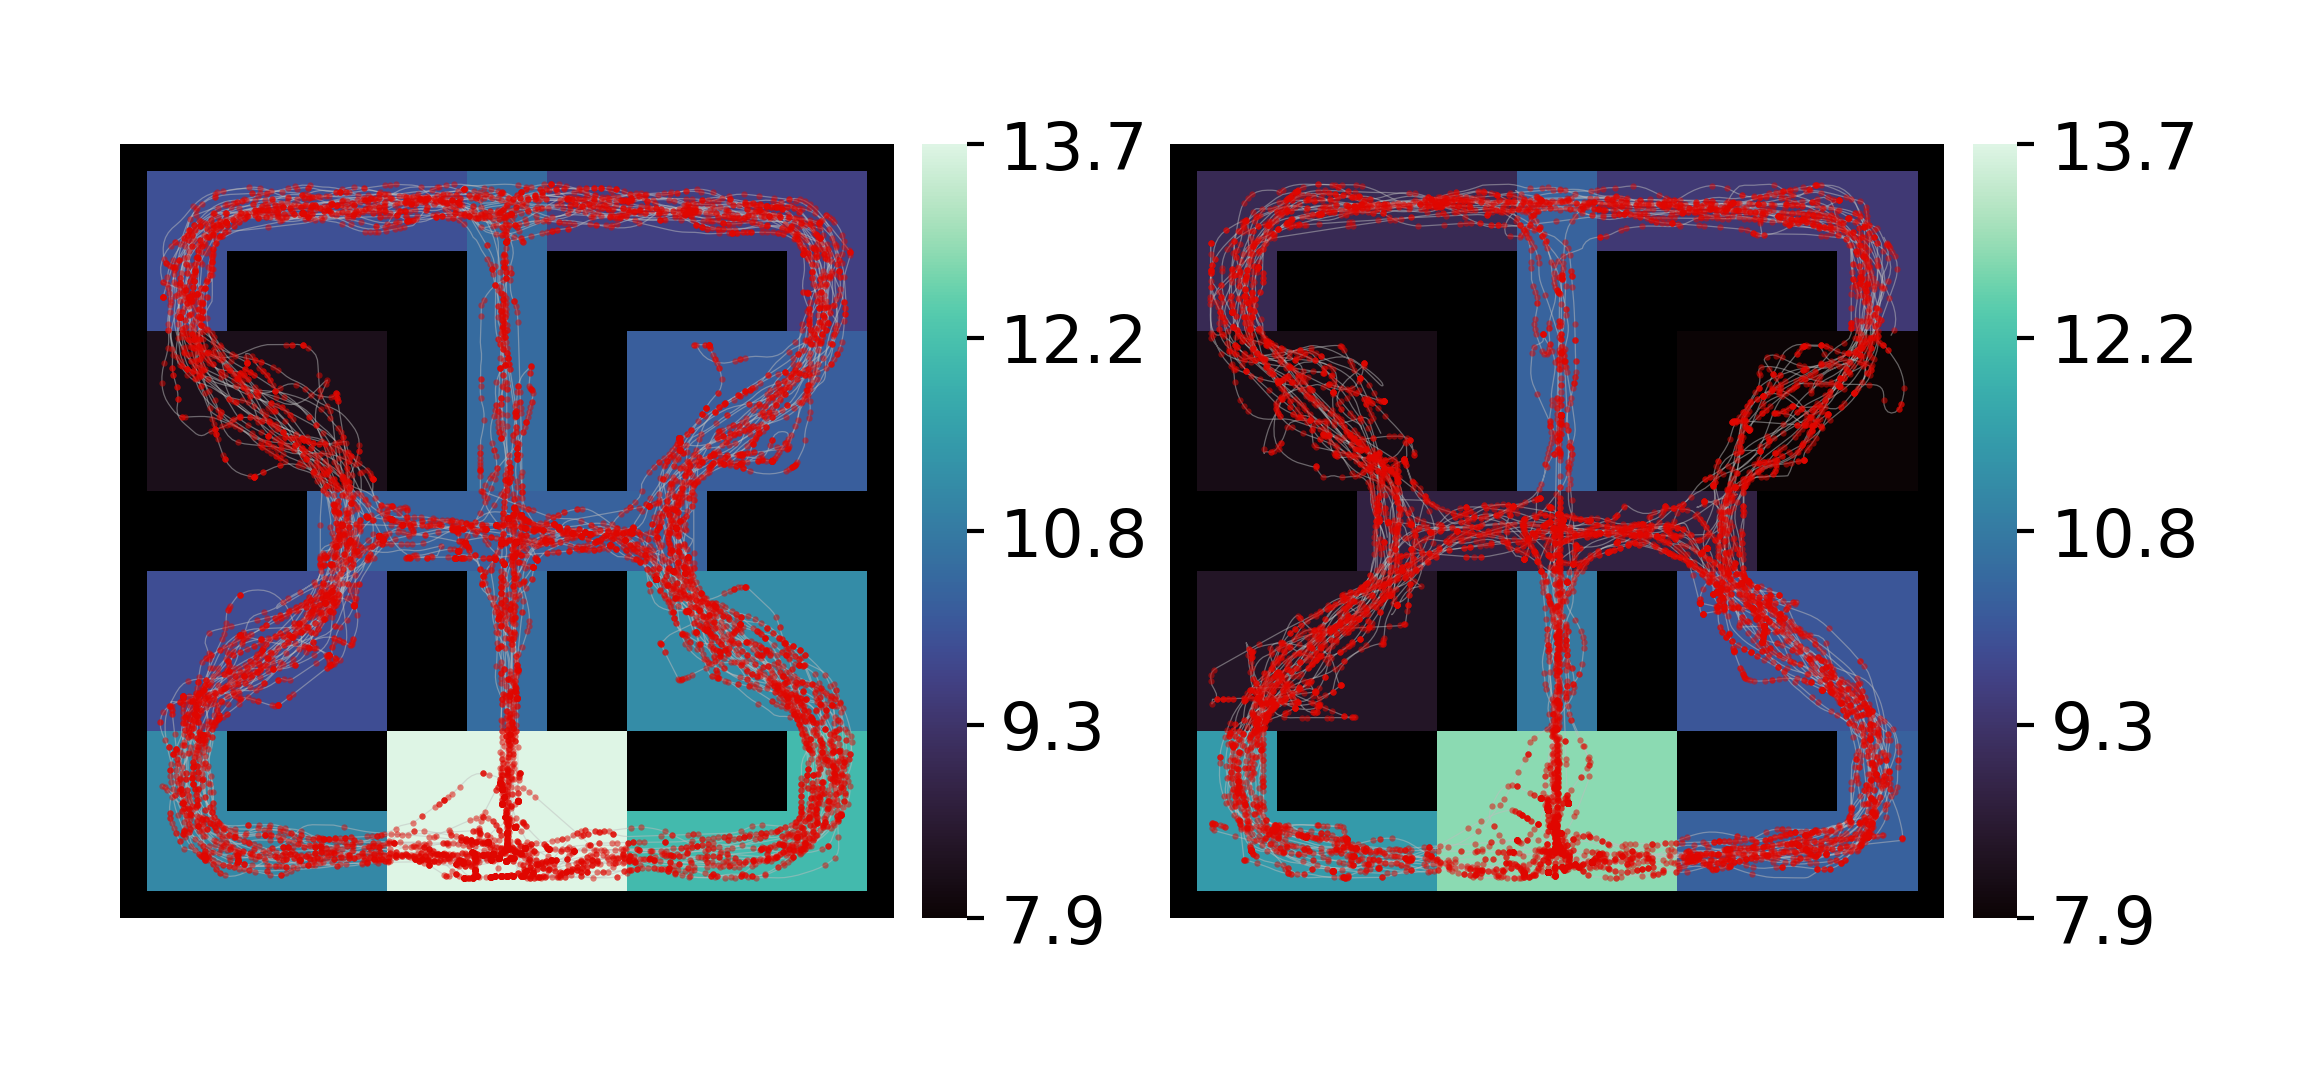

In [124]:
# Plot a neuron's firing rate by maze location.
subj_sess_unit = ['U554_ses0-9-2']
savefig = 0
overwrite = 1
plot_bw = 0
game_states = ['Encoding', 'Retrieval']
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 7}
base_color = 'w'
show_spikes = True
only_show_spikes_when_moving = False
# ----------------------------------

if subj_sess_unit is None:
    neurons = sig_cells['place']
elif isinstance(subj_sess_unit, str):
    neurons = [subj_sess_unit]
else:
    neurons = subj_sess_unit
    
if plot_bw:
    fr_cmap = 'binary_r'
    base_lw = 0.2
    nav_color = '#296eb4'
    nav_alpha = 0.5
    nav_lw = 0.075
    spike_fill_color = '#e10600'
    spike_edge_color = 'k'
    spike_alpha = 0.5
    spike_markersize = 0.5
    spike_mew = 0
    background_color = 'k'
else:
    fr_cmap = 'mako' # 'rocket'
    base_lw = 0
    nav_color = '#bebebe' # '#3d79b6'
    nav_alpha = 0.5
    nav_lw = 0.075
    spike_fill_color = '#e10600' # '#7ccaa5'
    spike_edge_color = 'k'
    spike_alpha = 0.5
    spike_markersize = 0.75 # 0.55
    spike_mew = 0 # 0.025
    background_color = 'k'

for subj_sess_unit in neurons:
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    fig, ax = time_cell_plots.plot_firing_maze2(subj_sess,
                                                neuron,
                                                font=font,
                                                base_color=base_color,
                                                base_lw=base_lw,
                                                fr_cmap=fr_cmap,
                                                show_spikes=show_spikes,
                                                only_show_spikes_when_moving=only_show_spikes_when_moving,
                                                nav_lw=nav_lw,
                                                nav_color=nav_color,
                                                nav_alpha=nav_alpha,
                                                spike_marker='.',
                                                spike_fill_color=spike_fill_color,
                                                spike_edge_color=spike_edge_color,
                                                spike_alpha=spike_alpha,
                                                spike_markersize=spike_markersize,
                                                spike_mew=spike_mew,
                                                wall_cmap=sns.color_palette("light:{}".format(background_color), as_cmap=True),
                                                background_color=background_color,
#                                                 vmin=2.5,
#                                                 vmax=1,
                                                dpi=dpi)

    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_navigation2', 'all', 
                           '{}-CSC{}-unit{}-{}-{}-{}-place_firing.png'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states), fr_cmap))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        filename = filename.replace('.png', '.pdf')
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)

print('{}-{}, {}'.format(subj_sess, neuron, '_'.join(game_states)))
fig.show()

# Time vs. place remapping

In [59]:
delay_time_cells = ['U518_ses1-37-1', 'U518_ses1-11-1', 'U518_ses1-73-2',
                    'U526_ses0-21-1', 'U518_ses1-12-1', 'U518_ses1-15-2',
                    'U518_ses0-36-1', 'U518_ses0-78-3', 'U518_ses1-38-1',
                    'U518_ses0-15-1', 'U518_ses0-16-2', 'U518_ses0-4-1',
                    'U518_ses0-78-1', 'U518_ses0-42-1', 'U518_ses0-9-1',
                    'U518_ses1-4-1',  'U518_ses0-32-1', 'U518_ses0-4-2',
                    'U518_ses0-16-1', 'U518_ses0-78-2', 'U518_ses0-73-1',
                    'U518_ses0-30-1', 'U518_ses0-38-2', 'U521_ses0-19-2',
                    'U518_ses0-40-1', 'U521_ses0-19-1', 'U518_ses0-13-2',
                    'U518_ses0-11-1', 'U527_ses0-17-1', 'U530_ses0-73-1',
                    'U530_ses1-13-1', 'U530_ses0-75-1', 'U530_ses0-82-2',
                    'U527_ses0-45-1', 'U527_ses0-12-1', 'U527_ses0-57-1',
                    'U530_ses0-13-1', 'U530_ses0-20-1', 'U530_ses0-5-1',
                    'U530_ses0-48-3', 'U530_ses0-67-1', 'U530_ses1-16-3',
                    'U530_ses1-71-1', 'U536_ses0-22-1', 'U536_ses0-20-1',
                    'U536_ses0-20-4', 'U536_ses0-24-2', 'U530_ses1-79-1',
                    'U532_ses0-5-6',  'U530_ses1-80-3', 'U532_ses0-5-4',
                    'U532_ses0-5-1',  'U532_ses0-8-1',  'U532_ses0-4-1',
                    'U532_ses0-16-1', 'U532_ses0-8-2',  'U532_ses0-10-1',
                    'U532_ses0-11-1', 'U532_ses0-20-1', 'U532_ses0-7-1',
                    'U532_ses0-6-1',  'U532_ses0-22-1', 'U532_ses0-21-1',
                    'U532_ses0-12-1', 'U532_ses0-24-1', 'U532_ses0-21-2',
                    'U532_ses0-42-3', 'U532_ses0-19-1', 'U532_ses0-23-1',
                    'U532_ses0-46-1', 'U532_ses0-47-1', 'U532_ses0-45-3',
                    'U536_ses0-8-1',  'U536_ses0-29-1', 'U536_ses0-31-2',
                    'U536_ses0-36-1', 'U536_ses0-38-1', 'U536_ses0-36-2',
                    'U536_ses0-38-2', 'U536_ses0-39-3', 'U540_ses0-40-1',
                    'U540_ses0-41-1', 'U536_ses0-58-1', 'U536_ses0-60-1',
                    'U536_ses0-59-1', 'U536_ses0-63-1', 'U536_ses0-65-1',
                    'U537_ses0-24-1', 'U536_ses0-72-1', 'U537_ses0-10-1',
                    'U537_ses0-15-1', 'U537_ses0-33-2', 'U536_ses0-76-1',
                    'U539_ses0-14-2', 'U539_ses0-55-1', 'U540_ses0-11-1',
                    'U540_ses0-19-1', 'U540_ses0-33-1', 'U540_ses0-34-1']
delay_interval_cells = ['U518_ses1-78-1', 'U518_ses1-36-1', 'U518_ses0-78-3',
                        'U518_ses1-42-1', 'U518_ses1-4-1', 'U526_ses0-41-1',
                        'U521_ses0-20-1', 'U518_ses0-40-1', 'U526_ses0-14-2',
                        'U526_ses0-12-2', 'U526_ses0-17-3', 'U526_ses0-44-1',
                        'U530_ses0-71-1', 'U530_ses1-13-1', 'U530_ses1-15-1',
                        'U527_ses0-18-1', 'U527_ses0-44-4', 'U527_ses0-43-2',
                        'U527_ses0-45-2', 'U527_ses0-44-2', 'U527_ses0-41-1',
                        'U527_ses0-58-2', 'U527_ses0-60-1', 'U527_ses0-12-1',
                        'U527_ses0-17-2', 'U527_ses0-44-3', 'U527_ses0-57-1',
                        'U527_ses0-9-1', 'U527_ses0-20-1', 'U527_ses0-16-2',
                        'U527_ses0-13-2', 'U527_ses0-43-1', 'U530_ses0-3-2',
                        'U530_ses0-5-2', 'U530_ses0-45-1', 'U530_ses0-69-1',
                        'U530_ses0-67-2', 'U530_ses0-68-1', 'U530_ses1-47-2',
                        'U532_ses0-5-2', 'U532_ses0-4-2', 'U532_ses0-2-2', 'U532_ses0-4-3',
                        'U532_ses0-6-3', 'U532_ses0-8-1', 'U532_ses0-4-1', 'U532_ses0-8-2',
                        'U532_ses0-9-1', 'U532_ses0-20-1', 'U532_ses0-12-2',
                        'U532_ses0-21-1', 'U532_ses0-17-1', 'U532_ses0-21-2',
                        'U532_ses0-46-2', 'U532_ses0-44-2', 'U532_ses0-46-1',
                        'U532_ses0-60-1', 'U536_ses0-34-2', 'U536_ses0-38-1',
                        'U536_ses0-36-2', 'U537_ses0-24-1', 'U536_ses0-72-1',
                        'U536_ses0-76-1', 'U539_ses0-11-2', 'U536_ses0-72-2',
                        'U539_ses0-55-1', 'U539_ses0-50-1', 'U540_ses0-36-1',
                        'U540_ses0-27-1', 'U540_ses0-22-1']
len(delay_time_cells), len(delay_interval_cells)

(99, 70)

In [92]:
(mod_pairs.query("(testvar=={})".format(nav_testvars))
          .groupby('testvar', observed=True)
          .agg({'sig': count_pct}))

,sig
testvar,
gameState,59/457 (12.9%)
time,23/457 (5.0%)
gameState:time,64/457 (14.0%)
place,60/457 (13.1%)
gameState:place,25/457 (5.5%)
time:place,43/457 (9.4%)
max-gameState,43/457 (9.4%)
max-time,20/457 (4.4%)
max-gameState:time,45/457 (9.8%)


In [1306]:
nav_testvars = ['gameState', 'gameState:time', 'place', 'time:place']
alpha = 0.05
delay_cells = od([('gameState', delay_interval_cells),
                  ('time', delay_time_cells)])
all_cells = mod_pairs['subj_sess_unit'].unique().tolist()

for delay_testvar in delay_cells:
    for nav_testvar in nav_testvars:
        
        _delay_cells = delay_cells[delay_testvar]
        _nav_cells = sig_cells[nav_testvar]
        
        ctab = [[len([x for x in all_cells if x not in set(_delay_cells + _nav_cells)]),
                 len([x for x in _delay_cells if x not in _nav_cells])],
                [len([x for x in _nav_cells if x not in _delay_cells]),
                 len([x for x in _delay_cells if x in _nav_cells])]]
        chi2, pval, dof, _ = stats.chi2_contingency(ctab)
        
        print('{:<18} in {:<18} : {:<13}, χ²({}) = {:.1f}, p = {:.6f}, reject = {}'
              .format('-'.join(('nav', nav_testvar)), '-'.join(('delay', delay_testvar)),
                      count_pct(np.isin(_nav_cells, _delay_cells)),
                      dof, chi2, pval, pval<alpha))
print('')
for delay_testvar in delay_cells:
    for nav_testvar in nav_testvars:
        _delay_cells = delay_cells[delay_testvar]
        _nav_cells = sig_cells[nav_testvar]
        print('{:<18} in {:<18} : {}'.format('-'.join(('delay', delay_testvar)), '-'.join(('nav', nav_testvar)),
                                             count_pct(np.isin(_delay_cells, _nav_cells))))

nav-gameState      in delay-gameState    : 12/59 (20.3%), χ²(1) = 0.9, p = 0.340102, reject = False
nav-gameState:time in delay-gameState    : 25/64 (39.1%), χ²(1) = 30.3, p = 0.000000, reject = True
nav-place          in delay-gameState    : 8/60 (13.3%) , χ²(1) = 0.1, p = 0.790616, reject = False
nav-time:place     in delay-gameState    : 4/43 (9.3%)  , χ²(1) = 0.9, p = 0.353306, reject = False
nav-gameState      in delay-time         : 16/59 (27.1%), χ²(1) = 0.8, p = 0.357196, reject = False
nav-gameState:time in delay-time         : 10/64 (15.6%), χ²(1) = 1.2, p = 0.270962, reject = False
nav-place          in delay-time         : 18/60 (30.0%), χ²(1) = 2.3, p = 0.130077, reject = False
nav-time:place     in delay-time         : 16/43 (37.2%), χ²(1) = 5.8, p = 0.016148, reject = True

delay-gameState    in nav-gameState      : 12/70 (17.1%)
delay-gameState    in nav-gameState:time : 25/70 (35.7%)
delay-gameState    in nav-place          : 8/70 (11.4%)
delay-gameState    in nav-time

In [91]:
_a = set(delay_interval_cells)
_b = set(sig_cells['gameState'])
dice_coef = (2 * len(_a & _b)) / (len(_a) + len(_b))
jaccard_score = len(_a & _b) / (len(_a) + len(_b) - len(_a & _b))
print('{} delay interval cells, {} nav interval cells, {} both, {} total'
      .format(len(_a), len(_b), len(_a & _b), len(_a | _b)),
      'dice = {:.2f}, jaccard = {:.2f}'.format(dice_coef, jaccard_score),
      sep='\n')

70 delay interval cells, 59 nav interval cells, 12 both, 117 total
dice = 0.19, jaccard = 0.10


In [88]:
12/70, 12/59, 70/453, 59/453

(0.17142857142857143,
 0.2033898305084746,
 0.1545253863134658,
 0.13024282560706402)

In [1310]:
for idx in [(ii, jj) for ii in range(len(testvars)) for jj in range(len(testvars)) if (jj>ii)]:
    testvar1 = testvars[idx[0]]
    testvar2 = testvars[idx[1]]
    
    ctab = [[len([x for x in all_cells if x not in set(sig_cells[testvar1] + sig_cells[testvar2])]),
                 len([x for x in sig_cells[testvar1] if x not in sig_cells[testvar2]])],
                [len([x for x in sig_cells[testvar2] if x not in sig_cells[testvar1]]),
                 len([x for x in sig_cells[testvar1] if x in sig_cells[testvar2]])]]
    chi2, pval, dof, _ = stats.chi2_contingency(ctab)
    
    print('{} in {}: {}, χ²({}) = {:.1f}, p = {:.6f}, reject = {}'
          .format(testvar1, testvar2,
                  count_pct(np.isin(sig_cells[testvar1], sig_cells[testvar2])),
                  dof, chi2, pval, pval<alpha))
    print('{} in {}: {}'.format(testvar2, testvar1,
                                count_pct(np.isin(sig_cells[testvar2], sig_cells[testvar1]))))

gameState in gameState:time: 13/59 (22.0%), χ²(1) = 2.9, p = 0.088489, reject = False
gameState:time in gameState: 13/64 (20.3%)
gameState in place: 5/59 (8.5%), χ²(1) = 0.9, p = 0.353484, reject = False
place in gameState: 5/60 (8.3%)
gameState in time:place: 7/59 (11.9%), χ²(1) = 0.2, p = 0.650363, reject = False
time:place in gameState: 7/43 (16.3%)
gameState:time in place: 10/64 (15.6%), χ²(1) = 0.2, p = 0.661388, reject = False
place in gameState:time: 10/60 (16.7%)
gameState:time in time:place: 4/64 (6.2%), χ²(1) = 0.5, p = 0.482278, reject = False
time:place in gameState:time: 4/43 (9.3%)
place in time:place: 4/60 (6.7%), χ²(1) = 0.3, p = 0.586811, reject = False
time:place in place: 4/43 (9.3%)


In [1360]:
# Compare encoding vs. retrieval firing rate similarity
# for time and place cells, respectively.
game_states = ['Encoding', 'Retrieval']
alpha = 0.05
verbose = False

# Get all time and place cells.
all_cells = mod_pairs['subj_sess_unit'].unique().tolist()
time_cells = list(set(sig_cells['time'] + sig_cells['gameState:time']))
place_cells = list(set(sig_cells['place'] + sig_cells['gameState:place']))
if verbose:
    print('{} time cells, {} place cells, {} time or place cells'
          .format(len(time_cells), len(place_cells), len(set(time_cells + place_cells))))
    print('{} time cells are place cells; {} place cells are time cells'
          .format(count_pct(np.isin(time_cells, place_cells)), count_pct(np.isin(place_cells, time_cells))))
    
# Load all event_spikes dataframes.
event_spikes = od([])
for subj_sess in sessions:
    event_spikes[subj_sess] = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    
# Get time cell encoding vs. retrieval correlations.
time_cell_corrs = od([])
for subj_sess_unit in time_cells:
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    _event_spikes = event_spikes[subj_sess].event_spikes
    
    fr_means = (_event_spikes.query("(gameState=={})".format(game_states))
                             .groupby(['gameState', 'time_step'], observed=True)[neuron]
                             .apply(np.mean))
    time_cell_corrs[subj_sess_unit] = stats.pearsonr(fr_means.iloc[fr_means.index.get_level_values('gameState')==game_states[0]].values,
                                                     fr_means.iloc[fr_means.index.get_level_values('gameState')==game_states[1]].values)[0]
    
place_cell_corrs = od([])
for subj_sess_unit in place_cells:
    subj_sess = subj_sess_unit.split('-')[0]
    neuron = '-'.join(subj_sess_unit.split('-')[1:])
    _event_spikes = event_spikes[subj_sess].event_spikes
    
    fr_means = (_event_spikes.query("(gameState=={})".format(game_states))
                             .groupby(['gameState', 'maze_region'], observed=True)[neuron]
                             .apply(np.mean))
    place_cell_corrs[subj_sess_unit] = stats.pearsonr(fr_means.iloc[fr_means.index.get_level_values('gameState')==game_states[0]].values,
                                                      fr_means.iloc[fr_means.index.get_level_values('gameState')==game_states[1]].values)[0]
    
# Do place cells have higher Encoding vs. Retrieval correlations than time cells?
dof = len(time_cell_corrs) + len(place_cell_corrs) - 2
tval, pval = stats.ttest_ind(list(place_cell_corrs.values()), list(time_cell_corrs.values()), equal_var=False)
    
print('{} time cells, r = {}'.format(len(time_cell_corrs), mean_sem(list(time_cell_corrs.values()))))
print('{} place cells, r = {}'.format(len(place_cell_corrs), mean_sem(list(place_cell_corrs.values()))))
print('t({}) = {:.1f}, p = {:.6f}, reject = {}'.format(dof, tval, pval, pval<alpha))

85 time cells, r = -0.00 ± 0.05
82 place cells, r = 0.31 ± 0.04
t(165) = 4.8, p = 0.000004, reject = True


In [41]:
len(list(np.unique(sig_cells['time'] + sig_cells['gameState:time'])))

85

In [49]:
qry = "(subj_sess_unit=={}) & (testvar=={}) & (sig==True)"
(mod_pairs
 .query(qry.format(list(np.unique(sig_cells['time'] + sig_cells['gameState:time'])), ['time', 'gameState:time']))
 .sort_values('z_lr', ascending=False)
 .drop_duplicates('subj_sess_unit'))

(85, 29)

In [53]:
# Do time and place cells differ in strength?
qry = "(subj_sess_unit=={}) & (testvar=={}) & (sig==True)"
zvals = od([])
for testvar in ['time', 'place']:
    zvals[testvar] = (mod_pairs
                      .query(qry.format(list(np.unique(sig_cells[testvar] + sig_cells['gameState:{}'.format(testvar)])),
                                        [testvar, 'gameState:{}'.format(testvar)]))
                      .sort_values('z_lr', ascending=False)
                      .drop_duplicates('subj_sess_unit')['z_lr'].tolist())

for key in zvals:
    print('{} {} cells, Z-LR = {}'.format(len(zvals[key]), key, mean_sem(zvals[key])))
dof = len(zvals['time']) + len(zvals['place']) - 2
tval, pval = stats.ttest_ind(zvals['time'], zvals['place'], equal_var=False)
print('t({}) = {:.1f}, p = {:.6f}, reject = {}'.format(dof, tval, pval, pval<alpha))

85 time cells, Z-LR = 3.63 ± 0.28
82 place cells, Z-LR = 3.40 ± 0.21
t(165) = 0.7, p = 0.511426, reject = False


In [1380]:
# Do time and place cells differ in strength?
qry = "(subj_sess_unit=={}) & (testvar=='{}')"
zvals = od([])
for testvar in ['gameState:time', 'place']:
    key = 'time' if 'time' in testvar else 'place'
    zvals[key] = zvals.get(key, []) + mod_pairs.query(qry.format(sig_cells[testvar], testvar))['z_lr'].tolist()

for key in zvals:
    print('{} {} cells, Z-LR = {}'.format(len(zvals[key]), key, mean_sem(zvals[key])))
dof = len(zvals['time']) + len(zvals['place']) - 2
tval, pval = stats.ttest_ind(zvals['time'], zvals['place'], equal_var=False)
print('t({}) = {:.1f}, p = {:.6f}, reject = {}'.format(dof, tval, pval, pval<alpha))

64 time cells, Z-LR = 3.81 ± 0.36
60 place cells, Z-LR = 3.62 ± 0.28
t(122) = 0.4, p = 0.684629, reject = False


-0.8082861102666302 0.8954141180031254


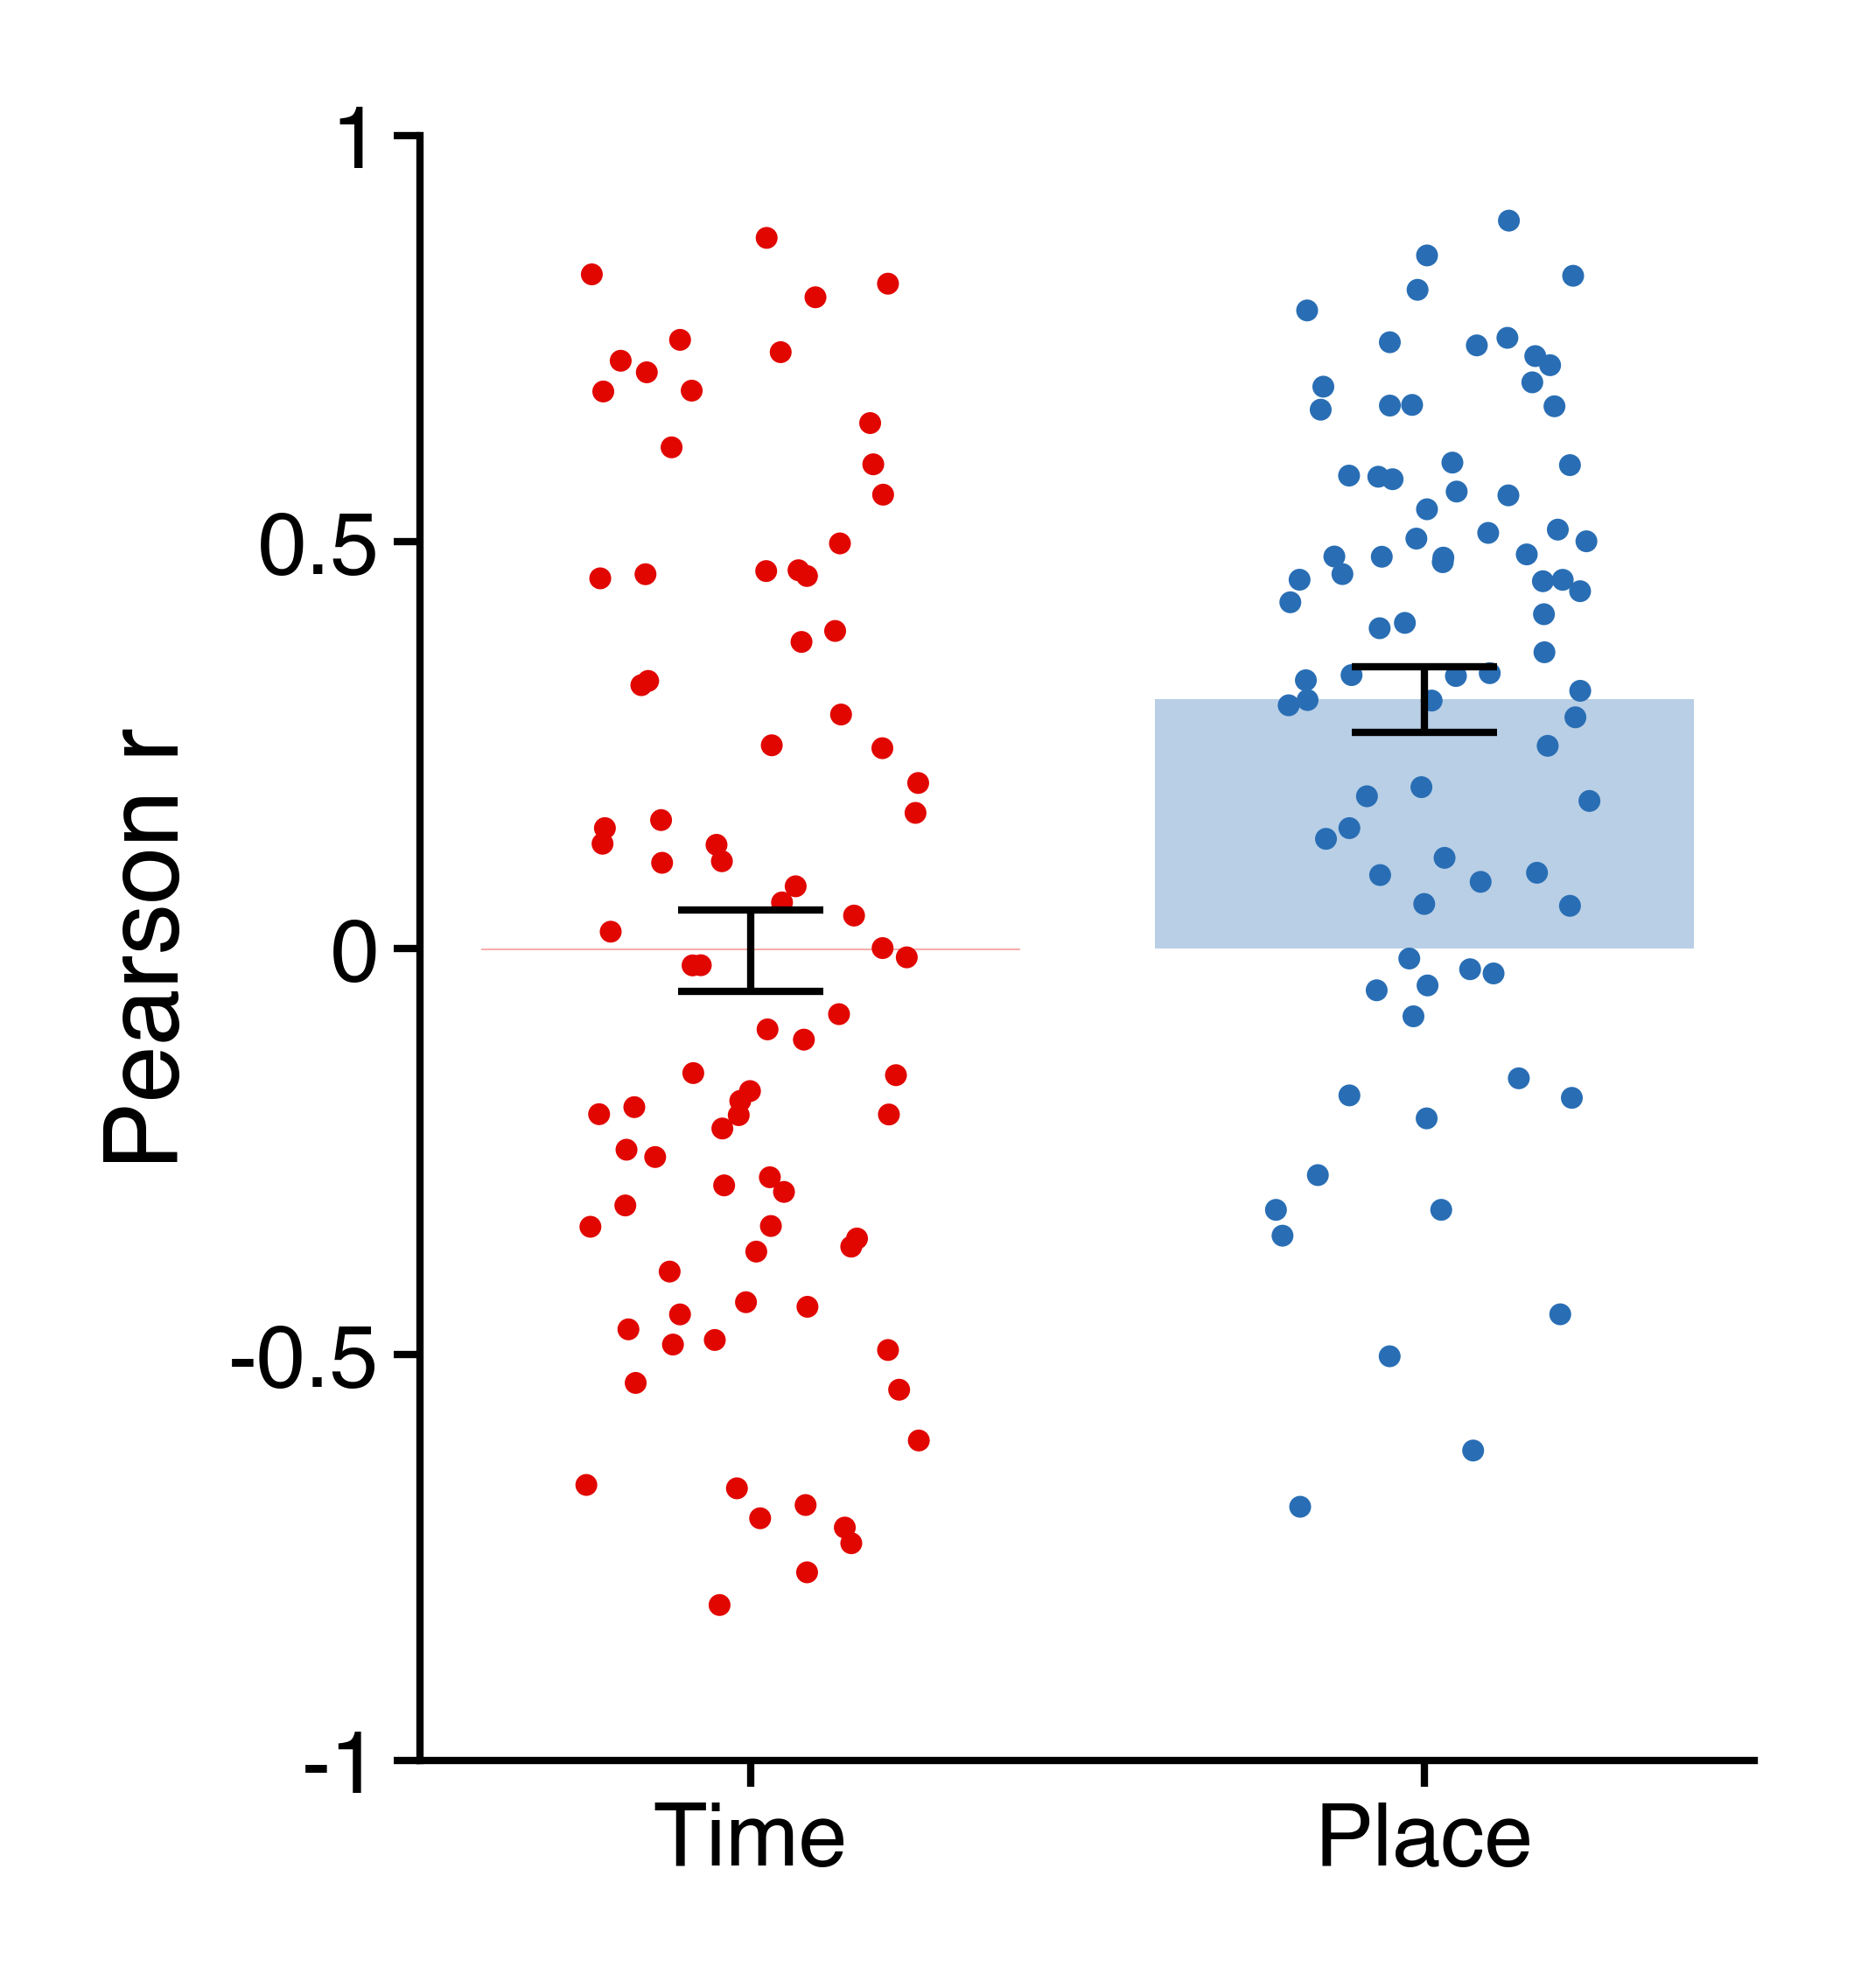

In [1375]:
savefig = 0
overwrite = 1
figsize = (colws[1]*0.8, colws[1])
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ymin = -1
ymax = 1
yticks = [-1, -0.5, 0, 0.5, 1]
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
linewidth = 1
fliersize = 2.5
palette = ['#e10600', '#296eb4']

# ---------------------
# Create the plot dataframe.
mean_corrs = pd.DataFrame(np.vstack((np.vstack((list(time_cell_corrs.keys()),
                                                ['time'] * len(time_cell_corrs),
                                                list(time_cell_corrs.values()))).T,
                                     np.vstack((list(place_cell_corrs.keys()),
                                                ['place'] * len(place_cell_corrs),
                                                list(place_cell_corrs.values()))).T)),
                           columns=['subj_sess_unit', 'level', 'value'])
mean_corrs['level'] = mean_corrs['level'].astype(pd.CategoricalDtype(['time', 'place'], ordered=True))
mean_corrs['value'] = mean_corrs['value'].astype(float)
print(mean_corrs['value'].min(), mean_corrs['value'].max())

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.barplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                      ci=None,
                      palette=palette,
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                        palette=palette,
                        size=1.5, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_corrs['level'].unique().size), mean_corrs.groupby('level')['value'].mean().values,
                 yerr=mean_corrs.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=spine_lw, capsize=5, capthick=spine_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_corrs['level'].unique().size))
ax[iax].set_xticklabels(['Time', 'Place'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin, ymax])
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
ax[iax].set_ylabel('Pearson r', fontsize=font['label'], labelpad=labelpad)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation2', 
                       'time_vs_place_cell_corrs-{}time_cells-{}place_cells-{}units.pdf'
                       .format(len(time_cell_corrs),len(place_cell_corrs), len(all_cells)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()